In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *
import networkx as nx

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE


In [3]:
from itertools import product

dimensions = [3,5,10]
incoming_edges = [2, 3, 4]
taus = [5, 10, 15, 20]
autocorrs = [False, True]
data_length = [10000]
runs = range(10)

setups = list(product(dimensions, incoming_edges, taus, autocorrs, data_length, runs))

# Experiment 4

In [ ]:
import pickle


def graph2Var(graph, dim, tau, mapping):
    inverted_mapping = {v: k for k, v in mapping.items()}
    params = np.zeros((dim * tau, dim))

    for x_t in range(dim):
        input_nodes = list(graph.predecessors(mapping[x_t]))
        inputs = np.array([inverted_mapping[x] for x in input_nodes])
        for i in inputs:
            params[i - dim, x_t] = graph.edges[(mapping[i], mapping[x_t])]['weight']
    return params

data_path = 'notebooks/ICML/icml_data_v2/'
results_path = 'notebooks/ICML/icml_results_v2/'
results = pd.read_csv(results_path + 'experiment4_new.csv')

names = ['PC1 incremental', 'PC extensive', 'PC incremental', 'PCMCI incremental']

for dim, in_edges, tau, autocorr, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    algo_graphs = pickle.load(open(results_path + 'exp3_graphs/' + 
                                   f'graphs-t={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    max_tau = 2*tau
    df_dict = {'dimension': [dim]*max_tau, 'max time lag': [tau]*max_tau, 'incoming edges': [in_edges]*max_tau, 
               'run': [run]*max_tau, 'autocorr': [autocorr]*max_tau, 'tau estimate': list(range(1, max_tau+1))}
    
    true_mapping, true_matrix = transform_ts(generator.ts, tau)
    true_params = graph2Var(generator.graph, dim, tau, true_mapping)
    
    # each algorithm
    for name in names:
        df_dict[name+' - MSE full'] = []
        df_dict[name+' - MSE TR'] = []
        df_dict[name+' - MSE FP'] = []
        graphs = algo_graphs[name]
        
        assert len(graphs) == max_tau
        for est_tau, graph in graphs.items():
            model = VAR(est_tau)
            node_mapping, data_matrix = transform_ts(generator.ts, est_tau)
            model.fit_from_graph(dim, data_matrix, graph, node_mapping)
            est_params = model.params[1:]
            mse_full, mse_tr, mse_fp = evaluate_parameters(true_params, est_params)
            df_dict[name+' - MSE full'].append(mse_full)
            df_dict[name+' - MSE TR'].append(mse_tr)
            df_dict[name+' - MSE FP'].append(mse_fp)
    
    # VAR for different tau'
    df_dict['complete VAR - MSE full'] = []
    df_dict['complete VAR - MSE TR'] = []
    df_dict['complete VAR - MSE FP'] = []
    for est_tau in range(1, max_tau+1):
        model = VAR(est_tau)
        model.fit(generator.ts)
        est_params = model.params[1:]
        mse_full, mse_tr, mse_fp = evaluate_parameters(true_params, est_params)
        df_dict['complete VAR - MSE full'].append(mse_full)
        df_dict['complete VAR - MSE TR'].append(mse_tr)
        df_dict['complete VAR - MSE FP'].append(mse_fp)
    
    # True Graph VAR
    model = VAR(tau)
    model.fit_from_graph(dim, true_matrix, generator.graph, true_mapping)
    est_params = model.params[1:]
    df_dict['true Graph'] = [evaluate_parameters(true_params, est_params)] * max_tau
    
    df = pd.DataFrame(df_dict)
    results = results.append(df)
    
    results.to_csv(results_path + f'experiment4_new.csv', index=False)
    

/home/Daniel.Thevessen/Causality/CIoTS/CIoTS/evaluation.py:123: RuntimeWarning: Mean of empty slice.
  mse_fp = se[(true_params == 0) & (est_params != 0)].mean()
/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Aggregate experiment4

In [30]:
results_path = 'notebooks/ICML/icml_results_v2/'

results3 = pd.read_csv(results_path + 'experiment3.csv')
# dim10 not done yet
# results3 = results3[results3.dimension != 10]
results4 = pd.read_csv(results_path + 'experiment4_new.csv')

names = ['PC1 incremental', 'PC extensive', 'PC incremental', 'PCMCI incremental']
stopper, params = ICStopper, {'patiency': 2}

def simulate_stopping(df, stopping, params, col):
    sorted_df = df.sort_values(by='tau estimate')
    idx = stopping.simulate(sorted_df[col].values, **params)
    return sorted_df['tau estimate'].iloc[idx]

results4_agg = pd.DataFrame()

for (dim, in_edges, tau, autocorr, run), res4 in results4.groupby([
    'dimension', 'incoming edges', 'max time lag', 'autocorr', 'run']):
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr, 'run': run}
    
    res3 = results3[(results3[['dimension', 'incoming edges', 'max time lag', 'autocorr', 'run'
                                 ]].values == (dim, in_edges, tau, autocorr, run)).all(axis=1)]
    for name in names:
        pred_tau = simulate_stopping(res3, stopper, params, name + '_bics')
        df_dict[name + ' tau estimate'] = pred_tau
        
        for mse_type in [' - MSE full', ' - MSE TR', ' - MSE FP']:
            df_dict[name+mse_type] = res4[res4['tau estimate'] == pred_tau][name + mse_type].iloc[0]
    
    for mse_type in [' - MSE full', ' - MSE TR', ' - MSE FP']:
        df_dict['VAR tau-1'+mse_type] = res4[res4['tau estimate'] == tau-1]['complete VAR' + mse_type].iloc[0]
        df_dict['VAR tau'+mse_type] = res4[res4['tau estimate'] == tau]['complete VAR' + mse_type].iloc[0]
        df_dict['VAR tau+1'+mse_type] = res4[res4['tau estimate'] == tau+1]['complete VAR' + mse_type].iloc[0]

    print(df_dict)
    df = pd.DataFrame(df_dict, index=[0])
    results4_agg = results4_agg.append(df)
    
    results4_agg.to_csv(results_path + f'experiment4_aggregated.csv', index=False)

{'dimension': 3, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.007512729687435309, 'PC1 incremental - MSE TR': 0.08059859967071245, 'PC1 incremental - MSE FP': 0.038510814768980606, 'PC extensive tau estimate': 7, 'PC extensive - MSE full': 0.013579998643570854, 'PC extensive - MSE TR': 0.07879396788623816, 'PC extensive - MSE FP': 0.06379601787125581, 'PC incremental tau estimate': 7, 'PC incremental - MSE full': 0.013579998643570854, 'PC incremental - MSE TR': 0.07879396788623816, 'PC incremental - MSE FP': 0.06379601787125581, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.0038309656173769204, 'PCMCI incremental - MSE TR': 0.05333873857130695, 'PCMCI incremental - MSE FP': 0.024754474136081082, 'VAR tau-1 - MSE full': 0.1198212989349352, 'VAR tau - MSE full': 0.02296304803927582, 'VAR tau+1 - MSE full': 0.007059359057924419, 'VAR tau-1 - MSE TR': 0.3186184562438405, 'VAR tau - 

{'dimension': 3, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'run': 7, 'PC1 incremental tau estimate': 1, 'PC1 incremental - MSE full': 0.025509493025253297, 'PC1 incremental - MSE TR': 0.10668082910238408, 'PC1 incremental - MSE FP': 0.253921105761047, 'PC extensive tau estimate': 4, 'PC extensive - MSE full': 0.18829757735633407, 'PC extensive - MSE TR': 0.2029099135289627, 'PC extensive - MSE FP': 1.0365616428373223, 'PC incremental tau estimate': 4, 'PC incremental - MSE full': 0.18829757735633407, 'PC incremental - MSE TR': 0.2029099135289627, 'PC incremental - MSE FP': 1.0365616428373223, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.007302113587909891, 'PCMCI incremental - MSE TR': 0.02727832804762876, 'PCMCI incremental - MSE FP': 0.08246257158508624, 'VAR tau-1 - MSE full': 0.03836600286264063, 'VAR tau - MSE full': 0.004410226898470414, 'VAR tau+1 - MSE full': 0.005489499914627475, 'VAR tau-1 - MSE TR': 0.18748648755852207, 'VAR tau - MSE TR': 0

{'dimension': 3, 'max time lag': 5, 'edges': 2, 'autocorr': True, 'run': 4, 'PC1 incremental tau estimate': 5, 'PC1 incremental - MSE full': 0.06549020199501254, 'PC1 incremental - MSE TR': 0.0353078265787681, 'PC1 incremental - MSE FP': 0.6573221626416629, 'PC extensive tau estimate': 6, 'PC extensive - MSE full': 0.008420059577236818, 'PC extensive - MSE TR': 0.036373132264212564, 'PC extensive - MSE FP': 0.03183125669821879, 'PC incremental tau estimate': 6, 'PC incremental - MSE full': 0.008420059577236818, 'PC incremental - MSE TR': 0.036373132264212564, 'PC incremental - MSE FP': 0.03183125669821879, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.00831227827677257, 'PCMCI incremental - MSE TR': 0.03832500786019536, 'PCMCI incremental - MSE FP': 0.03464598540132016, 'VAR tau-1 - MSE full': 0.033903795603403106, 'VAR tau - MSE full': 0.0030782873251633844, 'VAR tau+1 - MSE full': 0.003837274066580329, 'VAR tau-1 - MSE TR': 0.06719654223606072, 'VAR tau - MSE

{'dimension': 3, 'max time lag': 10, 'edges': 2, 'autocorr': False, 'run': 2, 'PC1 incremental tau estimate': 2, 'PC1 incremental - MSE full': 0.0071973874625277014, 'PC1 incremental - MSE TR': 0.1280021011116713, 'PC1 incremental - MSE FP': 0.003877183034568292, 'PC extensive tau estimate': 2, 'PC extensive - MSE full': 0.0071973874625277014, 'PC extensive - MSE TR': 0.1280021011116713, 'PC extensive - MSE FP': 0.003877183034568292, 'PC incremental tau estimate': 2, 'PC incremental - MSE full': 0.0071973874625277014, 'PC incremental - MSE TR': 0.1280021011116713, 'PC incremental - MSE FP': 0.003877183034568292, 'PCMCI incremental tau estimate': 1, 'PCMCI incremental - MSE full': 0.007111175248272737, 'PCMCI incremental - MSE TR': 0.12800115446890925, 'PCMCI incremental - MSE FP': nan, 'VAR tau-1 - MSE full': 0.04797594630902953, 'VAR tau - MSE full': 0.005711101839477066, 'VAR tau+1 - MSE full': 0.00820110951377691, 'VAR tau-1 - MSE TR': 0.06664090846823308, 'VAR tau - MSE TR': 0.0069

{'dimension': 3, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'run': 0, 'PC1 incremental tau estimate': 3, 'PC1 incremental - MSE full': 0.027824815244329868, 'PC1 incremental - MSE TR': 0.1278039488970236, 'PC1 incremental - MSE FP': 0.19342826170235367, 'PC extensive tau estimate': 11, 'PC extensive - MSE full': 0.009039236758601521, 'PC extensive - MSE TR': 0.04425544935067826, 'PC extensive - MSE FP': 0.04514412681322237, 'PC incremental tau estimate': 18, 'PC incremental - MSE full': 2.953189732363005e-05, 'PC incremental - MSE TR': 0.00030493081342059246, 'PC incremental - MSE FP': 0.0020397900456427353, 'PCMCI incremental tau estimate': 12, 'PCMCI incremental - MSE full': 0.01715680540988311, 'PCMCI incremental - MSE TR': 0.07847073940950985, 'PCMCI incremental - MSE FP': 0.16381404708311248, 'VAR tau-1 - MSE full': 0.20767487447363744, 'VAR tau - MSE full': 0.02736508321732847, 'VAR tau+1 - MSE full': 1.6408339638631142e+23, 'VAR tau-1 - MSE TR': 0.2313736797488581, 'VAR t

{'dimension': 3, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'run': 9, 'PC1 incremental tau estimate': 11, 'PC1 incremental - MSE full': 6.171022300542268e-06, 'PC1 incremental - MSE TR': 6.788124530596494e-05, 'PC1 incremental - MSE FP': nan, 'PC extensive tau estimate': 13, 'PC extensive - MSE full': 5.220959632586252e-06, 'PC extensive - MSE TR': 6.787247522362127e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 13, 'PC incremental - MSE full': 5.220959632586252e-06, 'PC incremental - MSE TR': 6.787247522362127e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 13, 'PCMCI incremental - MSE full': 5.220959632586252e-06, 'PCMCI incremental - MSE TR': 6.787247522362127e-05, 'PCMCI incremental - MSE FP': nan, 'VAR tau-1 - MSE full': 1.7312384297060815e+22, 'VAR tau - MSE full': 1.2314522579053694e+22, 'VAR tau+1 - MSE full': 8.308087083455973e+17, 'VAR tau-1 - MSE TR': 1.9923440902765848e+22, 'VAR tau - MSE TR': 1.2170735818709322e+22, 'VAR tau

{'dimension': 3, 'max time lag': 15, 'edges': 2, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 8, 'PC1 incremental - MSE full': 0.0071395886726457435, 'PC1 incremental - MSE TR': 0.10917509403614058, 'PC1 incremental - MSE FP': 0.03431043406559243, 'PC extensive tau estimate': 12, 'PC extensive - MSE full': 0.01114857309092394, 'PC extensive - MSE TR': 0.06847917137544914, 'PC extensive - MSE FP': 0.08416787223246436, 'PC incremental tau estimate': 12, 'PC incremental - MSE full': 0.01114857309092394, 'PC incremental - MSE TR': 0.06847917137544914, 'PC incremental - MSE FP': 0.08416787223246436, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 0.007221191665140609, 'PCMCI incremental - MSE TR': 0.10873121076775727, 'PCMCI incremental - MSE FP': 0.04030920127342983, 'VAR tau-1 - MSE full': 0.010287407274747765, 'VAR tau - MSE full': 0.006562110241284163, 'VAR tau+1 - MSE full': 1.7246321476493388e+22, 'VAR tau-1 - MSE TR': 0.0339548216091354, 'VAR tau 

{'dimension': 3, 'max time lag': 15, 'edges': 2, 'autocorr': True, 'run': 7, 'PC1 incremental tau estimate': 5, 'PC1 incremental - MSE full': 0.006700122284012109, 'PC1 incremental - MSE TR': 0.09138942930231336, 'PC1 incremental - MSE FP': 0.03468021478462556, 'PC extensive tau estimate': 6, 'PC extensive - MSE full': 0.023594427146336257, 'PC extensive - MSE TR': 0.1490127198639668, 'PC extensive - MSE FP': 0.28473512940623713, 'PC incremental tau estimate': 5, 'PC incremental - MSE full': 0.02385177559344072, 'PC incremental - MSE TR': 0.14119536518561046, 'PC incremental - MSE FP': 0.2613033479537017, 'PCMCI incremental tau estimate': 4, 'PCMCI incremental - MSE full': 0.008002750788233608, 'PCMCI incremental - MSE TR': 0.09689829754717053, 'PCMCI incremental - MSE FP': 0.06103699520683459, 'VAR tau-1 - MSE full': 0.08051205933104252, 'VAR tau - MSE full': 0.02959362804242398, 'VAR tau+1 - MSE full': 0.015714703691125074, 'VAR tau-1 - MSE TR': 0.3080564430510129, 'VAR tau - MSE TR'

{'dimension': 3, 'max time lag': 20, 'edges': 2, 'autocorr': False, 'run': 4, 'PC1 incremental tau estimate': 1, 'PC1 incremental - MSE full': 0.005944687017241438, 'PC1 incremental - MSE TR': 0.1610936179883479, 'PC1 incremental - MSE FP': 0.025870488793342847, 'PC extensive tau estimate': 1, 'PC extensive - MSE full': 0.005931563186654182, 'PC extensive - MSE TR': 0.16000000000000006, 'PC extensive - MSE FP': 0.03589379119925083, 'PC incremental tau estimate': 1, 'PC incremental - MSE full': 0.005931563186654182, 'PC incremental - MSE TR': 0.16000000000000006, 'PC incremental - MSE FP': 0.03589379119925083, 'PCMCI incremental tau estimate': 1, 'PCMCI incremental - MSE full': 0.005931563186654182, 'PCMCI incremental - MSE TR': 0.16000000000000006, 'PCMCI incremental - MSE FP': 0.03589379119925083, 'VAR tau-1 - MSE full': 0.0153165064312711, 'VAR tau - MSE full': 9.352652722945752e+21, 'VAR tau+1 - MSE full': 9.239881587909126e+22, 'VAR tau-1 - MSE TR': 0.2042306574121408, 'VAR tau - M

{'dimension': 3, 'max time lag': 20, 'edges': 2, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 14, 'PC1 incremental - MSE full': 0.002524398139622373, 'PC1 incremental - MSE TR': 0.0367383395760775, 'PC1 incremental - MSE FP': 0.020624434824554942, 'PC extensive tau estimate': 30, 'PC extensive - MSE full': 0.005314221015874985, 'PC extensive - MSE TR': 0.025170984546999974, 'PC extensive - MSE FP': 0.04833203253452985, 'PC incremental tau estimate': 21, 'PC incremental - MSE full': 0.015918732310314963, 'PC incremental - MSE TR': 0.02634400445559226, 'PC incremental - MSE FP': 0.1259792893885999, 'PCMCI incremental tau estimate': 9, 'PCMCI incremental - MSE full': 0.00335866112651228, 'PCMCI incremental - MSE TR': 0.05470407960245527, 'PCMCI incremental - MSE FP': 0.022444457270022568, 'VAR tau-1 - MSE full': 0.07849816826244163, 'VAR tau - MSE full': 0.09996327085422073, 'VAR tau+1 - MSE full': 0.015067612174096306, 'VAR tau-1 - MSE TR': 0.08775712083191202, 'VAR tau - 

{'dimension': 3, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 7, 'PC1 incremental - MSE full': 4.735970746347873e-06, 'PC1 incremental - MSE TR': 4.262373671713086e-05, 'PC1 incremental - MSE FP': nan, 'PC extensive tau estimate': 7, 'PC extensive - MSE full': 4.735970746347873e-06, 'PC extensive - MSE TR': 4.262373671713086e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 7, 'PC incremental - MSE full': 4.735970746347873e-06, 'PC incremental - MSE TR': 4.262373671713086e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 7, 'PCMCI incremental - MSE full': 4.735970746347873e-06, 'PCMCI incremental - MSE TR': 4.262373671713086e-05, 'PCMCI incremental - MSE FP': nan, 'VAR tau-1 - MSE full': 0.08228787214267022, 'VAR tau - MSE full': 0.000285045209592477, 'VAR tau+1 - MSE full': 0.0026620267709431163, 'VAR tau-1 - MSE TR': 0.1414313418604404, 'VAR tau - MSE TR': 0.00028089601182599823, 'VAR tau+1 - MSE TR':

{'dimension': 3, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'run': 7, 'PC1 incremental tau estimate': 5, 'PC1 incremental - MSE full': 1.4260415920053281e-06, 'PC1 incremental - MSE TR': 9.167410234319968e-06, 'PC1 incremental - MSE FP': nan, 'PC extensive tau estimate': 6, 'PC extensive - MSE full': 1.1834292656766429e-06, 'PC extensive - MSE TR': 9.129311478076958e-06, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 6, 'PC incremental - MSE full': 1.1834292656766429e-06, 'PC incremental - MSE TR': 9.129311478076958e-06, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 1.1834292656766429e-06, 'PCMCI incremental - MSE TR': 9.129311478076958e-06, 'PCMCI incremental - MSE FP': nan, 'VAR tau-1 - MSE full': 0.08251662336002512, 'VAR tau - MSE full': 0.001049253642876965, 'VAR tau+1 - MSE full': 0.0027500061353371947, 'VAR tau-1 - MSE TR': 0.11912324573360575, 'VAR tau - MSE TR': 0.0003532198161315297, 'VAR tau+1 - MSE 

{'dimension': 3, 'max time lag': 5, 'edges': 3, 'autocorr': True, 'run': 4, 'PC1 incremental tau estimate': 4, 'PC1 incremental - MSE full': 0.025213253036885163, 'PC1 incremental - MSE TR': 0.07057844345070191, 'PC1 incremental - MSE FP': 0.031961673916823245, 'PC extensive tau estimate': 8, 'PC extensive - MSE full': 0.010254854216848332, 'PC extensive - MSE TR': 0.05153752866521805, 'PC extensive - MSE FP': 0.01712845137578047, 'PC incremental tau estimate': 8, 'PC incremental - MSE full': 0.010254854216848332, 'PC incremental - MSE TR': 0.05153752866521805, 'PC incremental - MSE FP': 0.01712845137578047, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.009318776968713263, 'PCMCI incremental - MSE TR': 0.058041388028959376, 'PCMCI incremental - MSE FP': 0.023698878472780183, 'VAR tau-1 - MSE full': 0.07869749198688364, 'VAR tau - MSE full': 0.020396052751032543, 'VAR tau+1 - MSE full': 0.007651661333095895, 'VAR tau-1 - MSE TR': 0.08823248122676948, 'VAR tau -

{'dimension': 3, 'max time lag': 10, 'edges': 3, 'autocorr': False, 'run': 1, 'PC1 incremental tau estimate': 12, 'PC1 incremental - MSE full': 1.917309373613982e-06, 'PC1 incremental - MSE TR': 2.5883676543788754e-05, 'PC1 incremental - MSE FP': nan, 'PC extensive tau estimate': 10, 'PC extensive - MSE full': 2.2792341279378187e-06, 'PC extensive - MSE TR': 2.5641383939300448e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 2.2792341279378187e-06, 'PC incremental - MSE TR': 2.5641383939300448e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 2.2792341279378187e-06, 'PCMCI incremental - MSE TR': 2.5641383939300448e-05, 'PCMCI incremental - MSE FP': nan, 'VAR tau-1 - MSE full': 0.03704437836625818, 'VAR tau - MSE full': 0.003289175870868109, 'VAR tau+1 - MSE full': 3.699423047034452e+22, 'VAR tau-1 - MSE TR': 0.05182668674970915, 'VAR tau - MSE TR': 0.002602232628849509, 'VAR tau+1

{'dimension': 3, 'max time lag': 10, 'edges': 3, 'autocorr': False, 'run': 9, 'PC1 incremental tau estimate': 19, 'PC1 incremental - MSE full': 0.005980323581263322, 'PC1 incremental - MSE TR': 0.06445089673280886, 'PC1 incremental - MSE FP': 0.03161266155719631, 'PC extensive tau estimate': 18, 'PC extensive - MSE full': 0.008218410643362081, 'PC extensive - MSE TR': 0.05768246810968439, 'PC extensive - MSE FP': 0.029008582544196363, 'PC incremental tau estimate': 19, 'PC incremental - MSE full': 0.007508045214329523, 'PC incremental - MSE TR': 0.05640696865827208, 'PC incremental - MSE FP': 0.031048520549036, 'PCMCI incremental tau estimate': 19, 'PCMCI incremental - MSE full': 0.0060970583600163854, 'PCMCI incremental - MSE TR': 0.06082991051036319, 'PCMCI incremental - MSE FP': 0.038086752689964073, 'VAR tau-1 - MSE full': 0.05937635050007799, 'VAR tau - MSE full': 0.05191504277327906, 'VAR tau+1 - MSE full': 0.0500748870854322, 'VAR tau-1 - MSE TR': 0.0726963520180423, 'VAR tau - 

{'dimension': 3, 'max time lag': 10, 'edges': 3, 'autocorr': True, 'run': 8, 'PC1 incremental tau estimate': 13, 'PC1 incremental - MSE full': 0.0033371814279616672, 'PC1 incremental - MSE TR': 0.02009783705991597, 'PC1 incremental - MSE FP': 0.033874803882487856, 'PC extensive tau estimate': 10, 'PC extensive - MSE full': 1.3371789304126759e-05, 'PC extensive - MSE TR': 0.00010940554885194622, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 1.3371789304126759e-05, 'PC incremental - MSE TR': 0.00010940554885194622, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.004162246530071796, 'PCMCI incremental - MSE TR': 0.01886781319577544, 'PCMCI incremental - MSE FP': 0.055685414184310604, 'VAR tau-1 - MSE full': 0.01571460583377945, 'VAR tau - MSE full': 0.0033324115564563345, 'VAR tau+1 - MSE full': 0.00418561875818885, 'VAR tau-1 - MSE TR': 0.02145291205819573, 'VAR tau - MSE TR': 0.008011

{'dimension': 3, 'max time lag': 15, 'edges': 3, 'autocorr': False, 'run': 7, 'PC1 incremental tau estimate': 15, 'PC1 incremental - MSE full': 8.626048800173258e-07, 'PC1 incremental - MSE TR': 1.4556457350292374e-05, 'PC1 incremental - MSE FP': nan, 'PC extensive tau estimate': 15, 'PC extensive - MSE full': 8.626048800173258e-07, 'PC extensive - MSE TR': 1.4556457350292374e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 15, 'PC incremental - MSE full': 8.626048800173258e-07, 'PC incremental - MSE TR': 1.4556457350292374e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 2, 'PCMCI incremental - MSE full': 0.012938054801351405, 'PCMCI incremental - MSE TR': 0.08771513131996679, 'PCMCI incremental - MSE FP': 0.14927376394610076, 'VAR tau-1 - MSE full': 0.3194373332940951, 'VAR tau - MSE full': 0.03140045849608842, 'VAR tau+1 - MSE full': 3.8733022675328476e+21, 'VAR tau-1 - MSE TR': 0.13884823685188533, 'VAR tau - MSE TR': 0.09077771732071772, 'VAR

{'dimension': 3, 'max time lag': 15, 'edges': 3, 'autocorr': True, 'run': 5, 'PC1 incremental tau estimate': 16, 'PC1 incremental - MSE full': 0.005334276390416943, 'PC1 incremental - MSE TR': 0.04500276122458256, 'PC1 incremental - MSE FP': 0.034138178343703945, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 0.009126402642502472, 'PC extensive - MSE TR': 0.052374591454344005, 'PC extensive - MSE FP': 0.03809399891616645, 'PC incremental tau estimate': 20, 'PC incremental - MSE full': 0.009126402642502472, 'PC incremental - MSE TR': 0.052374591454344005, 'PC incremental - MSE FP': 0.03809399891616645, 'PCMCI incremental tau estimate': 4, 'PCMCI incremental - MSE full': 0.011744152437887831, 'PCMCI incremental - MSE TR': 0.09612481287549213, 'PCMCI incremental - MSE FP': 0.04400730312370366, 'VAR tau-1 - MSE full': 0.06791280221494439, 'VAR tau - MSE full': 0.02248887646598096, 'VAR tau+1 - MSE full': 0.017571458723181846, 'VAR tau-1 - MSE TR': 0.06741621163732672, 'VAR tau

{'dimension': 3, 'max time lag': 20, 'edges': 3, 'autocorr': False, 'run': 3, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.008492288629007371, 'PC1 incremental - MSE TR': 0.13503374812477986, 'PC1 incremental - MSE FP': 0.026373056954299232, 'PC extensive tau estimate': 24, 'PC extensive - MSE full': 0.0019245225583511406, 'PC extensive - MSE TR': 0.02023584551847344, 'PC extensive - MSE FP': 0.031726263557007355, 'PC incremental tau estimate': 24, 'PC incremental - MSE full': 0.0020488382980569948, 'PC incremental - MSE TR': 0.02021310464619817, 'PC incremental - MSE FP': 0.02808442352107256, 'PCMCI incremental tau estimate': 24, 'PCMCI incremental - MSE full': 0.0012307410188429693, 'PCMCI incremental - MSE TR': 0.02013048430526217, 'PCMCI incremental - MSE FP': 0.026199046406996003, 'VAR tau-1 - MSE full': 0.063001525969233, 'VAR tau - MSE full': 0.028801149743898236, 'VAR tau+1 - MSE full': 0.0149677323113212, 'VAR tau-1 - MSE TR': 0.04488661882506699, 'VAR ta

{'dimension': 3, 'max time lag': 20, 'edges': 3, 'autocorr': True, 'run': 1, 'PC1 incremental tau estimate': 11, 'PC1 incremental - MSE full': 0.003919663529377684, 'PC1 incremental - MSE TR': 0.04721941088156404, 'PC1 incremental - MSE FP': 0.01984378638703067, 'PC extensive tau estimate': 23, 'PC extensive - MSE full': 0.004822952291528656, 'PC extensive - MSE TR': 0.03026408662552555, 'PC extensive - MSE FP': 0.02887191294727842, 'PC incremental tau estimate': 25, 'PC incremental - MSE full': 0.004490900297242279, 'PC incremental - MSE TR': 0.029894521515432537, 'PC incremental - MSE FP': 0.028335578638883575, 'PCMCI incremental tau estimate': 11, 'PCMCI incremental - MSE full': 0.002752124702668961, 'PCMCI incremental - MSE TR': 0.033227133002805415, 'PCMCI incremental - MSE FP': 0.03221895014891606, 'VAR tau-1 - MSE full': 0.05747329330206832, 'VAR tau - MSE full': 0.007843480796875881, 'VAR tau+1 - MSE full': 1.2453147472721543e+23, 'VAR tau-1 - MSE TR': 0.1241599978395984, 'VAR 

{'dimension': 3, 'max time lag': 20, 'edges': 3, 'autocorr': True, 'run': 9, 'PC1 incremental tau estimate': 8, 'PC1 incremental - MSE full': 0.026177062623073875, 'PC1 incremental - MSE TR': 0.26281350907472, 'PC1 incremental - MSE FP': 0.20837361814060967, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 7.504610845076181e-06, 'PC extensive - MSE TR': 0.00013508299521137129, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 16, 'PC incremental - MSE full': 0.015421602125574715, 'PC incremental - MSE TR': 0.06725012412613139, 'PC incremental - MSE FP': 0.12372865537306675, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 0.024241643505137682, 'PCMCI incremental - MSE TR': 0.2396763659714179, 'PCMCI incremental - MSE FP': 0.2458415214013255, 'VAR tau-1 - MSE full': 0.0670033031414517, 'VAR tau - MSE full': 0.07569287003083094, 'VAR tau+1 - MSE full': 0.02777421087067261, 'VAR tau-1 - MSE TR': 0.11704165781600764, 'VAR tau - MSE TR': 0.129280576

{'dimension': 3, 'max time lag': 5, 'edges': 4, 'autocorr': False, 'run': 6, 'PC1 incremental tau estimate': 4, 'PC1 incremental - MSE full': 0.03843543337318037, 'PC1 incremental - MSE TR': 0.10158160359670168, 'PC1 incremental - MSE FP': 0.054906035832776943, 'PC extensive tau estimate': 7, 'PC extensive - MSE full': 0.016854214134312942, 'PC extensive - MSE TR': 0.04821036687050399, 'PC extensive - MSE FP': 0.09661863695944588, 'PC incremental tau estimate': 7, 'PC incremental - MSE full': 0.017355212659634054, 'PC incremental - MSE TR': 0.04806429030306828, 'PC incremental - MSE FP': 0.08753364207518037, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.07443234267524455, 'PCMCI incremental - MSE TR': 0.14625967191436112, 'PCMCI incremental - MSE FP': 0.2695512430346277, 'VAR tau-1 - MSE full': 0.11237750708329812, 'VAR tau - MSE full': 0.0004598563501981452, 'VAR tau+1 - MSE full': 0.006276913629573066, 'VAR tau-1 - MSE TR': 0.1972062941717776, 'VAR tau - MSE 

{'dimension': 3, 'max time lag': 5, 'edges': 4, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.02002691842076985, 'PC1 incremental - MSE TR': 0.04837993499919998, 'PC1 incremental - MSE FP': 0.0449038338591969, 'PC extensive tau estimate': 9, 'PC extensive - MSE full': 0.0068653913146852355, 'PC extensive - MSE TR': 0.027480159895950373, 'PC extensive - MSE FP': 0.024482065420885542, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.006150925808966218, 'PC incremental - MSE TR': 0.02754689339119026, 'PC incremental - MSE FP': 0.020990851916287, 'PCMCI incremental tau estimate': 9, 'PCMCI incremental - MSE full': 0.014401116049755603, 'PCMCI incremental - MSE TR': 0.05516036598271607, 'PCMCI incremental - MSE FP': 0.03942452762721789, 'VAR tau-1 - MSE full': 0.022289078091641882, 'VAR tau - MSE full': 0.004116081428792555, 'VAR tau+1 - MSE full': 0.019208280621164503, 'VAR tau-1 - MSE TR': 0.04233149883025048, 'VAR tau - MS

{'dimension': 3, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 11, 'PC1 incremental - MSE full': 0.007435328515108669, 'PC1 incremental - MSE TR': 0.04304807718237354, 'PC1 incremental - MSE FP': 0.016886199754405824, 'PC extensive tau estimate': 14, 'PC extensive - MSE full': 0.013183748579200159, 'PC extensive - MSE TR': 0.03995025297029419, 'PC extensive - MSE FP': 0.0422053316191318, 'PC incremental tau estimate': 14, 'PC incremental - MSE full': 0.013438550386216138, 'PC incremental - MSE TR': 0.039902954413191576, 'PC incremental - MSE FP': 0.04337221056089053, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.00916490787084699, 'PCMCI incremental - MSE TR': 0.04341078300393608, 'PCMCI incremental - MSE FP': 0.0303912312328996, 'VAR tau-1 - MSE full': 0.033181131499179416, 'VAR tau - MSE full': 0.004683904919677302, 'VAR tau+1 - MSE full': 0.003332355693647009, 'VAR tau-1 - MSE TR': 0.034152766539101945, 'VAR ta

{'dimension': 3, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'run': 7, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 7.114564405765871e-06, 'PC1 incremental - MSE TR': 4.379643327554513e-05, 'PC1 incremental - MSE FP': 0.000158550030487932, 'PC extensive tau estimate': 14, 'PC extensive - MSE full': 0.006776507604680348, 'PC extensive - MSE TR': 0.018089650341668567, 'PC extensive - MSE FP': 0.05037336957164383, 'PC incremental tau estimate': 12, 'PC incremental - MSE full': 0.004278392309806672, 'PC incremental - MSE TR': 0.016690340625906894, 'PC incremental - MSE FP': 0.02531569296128589, 'PCMCI incremental tau estimate': 15, 'PCMCI incremental - MSE full': 0.0021606252861747807, 'PCMCI incremental - MSE TR': 0.0176313577638111, 'PCMCI incremental - MSE FP': 0.03257982607722445, 'VAR tau-1 - MSE full': 0.013148957972012407, 'VAR tau - MSE full': 0.010813030985956687, 'VAR tau+1 - MSE full': 0.004024168478846592, 'VAR tau-1 - MSE TR': 0.02748405562189801, '

{'dimension': 3, 'max time lag': 10, 'edges': 4, 'autocorr': True, 'run': 4, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.022184191943888, 'PC1 incremental - MSE TR': 0.1043048336811645, 'PC1 incremental - MSE FP': 0.05823767609952555, 'PC extensive tau estimate': 9, 'PC extensive - MSE full': 0.011567875737445258, 'PC extensive - MSE TR': 0.05393508783299461, 'PC extensive - MSE FP': 0.030904788594649388, 'PC incremental tau estimate': 9, 'PC incremental - MSE full': 0.011567875737445258, 'PC incremental - MSE TR': 0.05393508783299461, 'PC incremental - MSE FP': 0.030904788594649388, 'PCMCI incremental tau estimate': 7, 'PCMCI incremental - MSE full': 0.06527455542444019, 'PCMCI incremental - MSE TR': 0.26434731610731954, 'PCMCI incremental - MSE FP': 0.18755345221572786, 'VAR tau-1 - MSE full': 0.6429495376139951, 'VAR tau - MSE full': 2.503248250349589, 'VAR tau+1 - MSE full': 0.046020512124181616, 'VAR tau-1 - MSE TR': 0.3838792600303335, 'VAR tau - MSE TR': 

{'dimension': 3, 'max time lag': 15, 'edges': 4, 'autocorr': False, 'run': 2, 'PC1 incremental tau estimate': 15, 'PC1 incremental - MSE full': 0.0021254521766337414, 'PC1 incremental - MSE TR': 0.016333702842118034, 'PC1 incremental - MSE FP': 0.018186321948027738, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 0.002420505797540189, 'PC extensive - MSE TR': 0.01406305755115206, 'PC extensive - MSE FP': 0.053386870588681835, 'PC incremental tau estimate': 16, 'PC incremental - MSE full': 0.0028879305863602498, 'PC incremental - MSE TR': 0.014174650851097962, 'PC incremental - MSE FP': 0.04096103237045007, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.0034536134185621037, 'PCMCI incremental - MSE TR': 0.028659807943494008, 'PCMCI incremental - MSE FP': 0.04628878666987507, 'VAR tau-1 - MSE full': 0.008259142782205912, 'VAR tau - MSE full': 0.004283933194733696, 'VAR tau+1 - MSE full': 0.004594487523994478, 'VAR tau-1 - MSE TR': 0.033078477261831336

{'dimension': 3, 'max time lag': 15, 'edges': 4, 'autocorr': False, 'run': 9, 'PC1 incremental tau estimate': 24, 'PC1 incremental - MSE full': 0.004510276025266804, 'PC1 incremental - MSE TR': 0.035886993801993436, 'PC1 incremental - MSE FP': 0.07243283620446272, 'PC extensive tau estimate': 21, 'PC extensive - MSE full': 0.011693472869545085, 'PC extensive - MSE TR': 0.1031000538118117, 'PC extensive - MSE FP': 0.0512364657340044, 'PC incremental tau estimate': 21, 'PC incremental - MSE full': 0.011693472869545085, 'PC incremental - MSE TR': 0.1031000538118117, 'PC incremental - MSE FP': 0.0512364657340044, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.020721258501744583, 'PCMCI incremental - MSE TR': 0.117772076603328, 'PCMCI incremental - MSE FP': 0.09386731594368193, 'VAR tau-1 - MSE full': 0.17749667041090933, 'VAR tau - MSE full': 0.8088805759607264, 'VAR tau+1 - MSE full': 0.3613314806227436, 'VAR tau-1 - MSE TR': 0.5544383502336314, 'VAR tau - MSE TR':

{'dimension': 3, 'max time lag': 15, 'edges': 4, 'autocorr': True, 'run': 7, 'PC1 incremental tau estimate': 18, 'PC1 incremental - MSE full': 0.0042595940330434215, 'PC1 incremental - MSE TR': 0.029998829176715026, 'PC1 incremental - MSE FP': 0.020005982975192408, 'PC extensive tau estimate': 21, 'PC extensive - MSE full': 0.009356468564360051, 'PC extensive - MSE TR': 0.024960198922207945, 'PC extensive - MSE FP': 0.07336681972794372, 'PC incremental tau estimate': 15, 'PC incremental - MSE full': 0.0134907834040595, 'PC incremental - MSE TR': 0.024729852240814358, 'PC incremental - MSE FP': 0.09064424849598857, 'PCMCI incremental tau estimate': 9, 'PCMCI incremental - MSE full': 0.012536371961056805, 'PCMCI incremental - MSE TR': 0.08265269865086099, 'PCMCI incremental - MSE FP': 0.02263098674898767, 'VAR tau-1 - MSE full': 2.221518706927112e+22, 'VAR tau - MSE full': 1.2267258859164113e+21, 'VAR tau+1 - MSE full': 7.339852744211802e+21, 'VAR tau-1 - MSE TR': 3.701079492963631e+22, 

{'dimension': 3, 'max time lag': 20, 'edges': 4, 'autocorr': False, 'run': 5, 'PC1 incremental tau estimate': 21, 'PC1 incremental - MSE full': 2.4246207561402745e-06, 'PC1 incremental - MSE TR': 4.582533229105118e-05, 'PC1 incremental - MSE FP': nan, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 2.5461235340714588e-06, 'PC extensive - MSE TR': 4.583022361328625e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 20, 'PC incremental - MSE full': 2.5461235340714588e-06, 'PC incremental - MSE TR': 4.583022361328625e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 13, 'PCMCI incremental - MSE full': 0.004687713870676515, 'PCMCI incremental - MSE TR': 0.06483206488137971, 'PCMCI incremental - MSE FP': 0.015035988300613503, 'VAR tau-1 - MSE full': 1.284440539953326e+23, 'VAR tau - MSE full': 3.753572520209143e+20, 'VAR tau+1 - MSE full': 4.470280899978361e+22, 'VAR tau-1 - MSE TR': 3.942532408163391e+22, 'VAR tau - MSE TR': 1.747919599949671

{'dimension': 3, 'max time lag': 20, 'edges': 4, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 11, 'PC1 incremental - MSE full': 0.014203232157575556, 'PC1 incremental - MSE TR': 0.10137943268445672, 'PC1 incremental - MSE FP': 0.04932810943317854, 'PC extensive tau estimate': 22, 'PC extensive - MSE full': 0.004413888967551978, 'PC extensive - MSE TR': 0.02272173893060897, 'PC extensive - MSE FP': 0.02665619658080785, 'PC incremental tau estimate': 22, 'PC incremental - MSE full': 0.004413888967551978, 'PC incremental - MSE TR': 0.02272173893060897, 'PC incremental - MSE FP': 0.02665619658080785, 'PCMCI incremental tau estimate': 11, 'PCMCI incremental - MSE full': 0.01479816177432756, 'PCMCI incremental - MSE TR': 0.10132512907908636, 'PCMCI incremental - MSE FP': 0.07148701144954164, 'VAR tau-1 - MSE full': 2.340404946582741, 'VAR tau - MSE full': 3.3003249350937547, 'VAR tau+1 - MSE full': 3.059856450041276, 'VAR tau-1 - MSE TR': 2.132338157426121, 'VAR tau - MSE TR':

{'dimension': 5, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'run': 1, 'PC1 incremental tau estimate': 8, 'PC1 incremental - MSE full': 0.004363622227352864, 'PC1 incremental - MSE TR': 0.03204605375179141, 'PC1 incremental - MSE FP': 0.13806597698816464, 'PC extensive tau estimate': 3, 'PC extensive - MSE full': 0.1262912570227172, 'PC extensive - MSE TR': 0.09613605716895827, 'PC extensive - MSE FP': 0.6445672415717422, 'PC incremental tau estimate': 3, 'PC incremental - MSE full': 0.1262912570227172, 'PC incremental - MSE TR': 0.09613605716895827, 'PC incremental - MSE FP': 0.6445672415717422, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 0.0039049907254607922, 'PCMCI incremental - MSE TR': 0.032228850308857776, 'PCMCI incremental - MSE FP': 0.11467741050089518, 'VAR tau-1 - MSE full': 0.16653278515073974, 'VAR tau - MSE full': 1.725599581939269, 'VAR tau+1 - MSE full': 0.20607580530121689, 'VAR tau-1 - MSE TR': 0.15967453487484545, 'VAR tau - MSE TR': 2

{'dimension': 5, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 7, 'PC1 incremental - MSE full': 1.1942078087077494e-05, 'PC1 incremental - MSE TR': 0.00012399229777102432, 'PC1 incremental - MSE FP': 0.000424970343764159, 'PC extensive tau estimate': 3, 'PC extensive - MSE full': 0.11934457556648365, 'PC extensive - MSE TR': 0.08573796304391414, 'PC extensive - MSE FP': 0.390574786538092, 'PC incremental tau estimate': 3, 'PC incremental - MSE full': 0.12389072241507924, 'PC incremental - MSE TR': 0.08535203286860198, 'PC incremental - MSE FP': 0.3850742098210232, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 6.211083663870667e-06, 'PCMCI incremental - MSE TR': 0.00012422167327741336, 'PCMCI incremental - MSE FP': nan, 'VAR tau-1 - MSE full': 0.1860976272086869, 'VAR tau - MSE full': 0.03573420081863805, 'VAR tau+1 - MSE full': 0.004212288251417532, 'VAR tau-1 - MSE TR': 0.06978804452933228, 'VAR tau - MSE TR': 0.0561

{'dimension': 5, 'max time lag': 5, 'edges': 2, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 7, 'PC1 incremental - MSE full': 0.012769932181580759, 'PC1 incremental - MSE TR': 0.0889796806789034, 'PC1 incremental - MSE FP': 0.05625268259956759, 'PC extensive tau estimate': 4, 'PC extensive - MSE full': 0.058539171535445675, 'PC extensive - MSE TR': 0.23812913489104384, 'PC extensive - MSE FP': 0.2340912136603157, 'PC incremental tau estimate': 4, 'PC incremental - MSE full': 0.0572108191698185, 'PC incremental - MSE TR': 0.2523406654347236, 'PC incremental - MSE FP': 0.2244161609804305, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.009005073947731361, 'PCMCI incremental - MSE TR': 0.06481849895390936, 'PCMCI incremental - MSE FP': 0.09838392327878463, 'VAR tau-1 - MSE full': 0.03249576848794428, 'VAR tau - MSE full': 0.10659742021311926, 'VAR tau+1 - MSE full': 0.07057811986661396, 'VAR tau-1 - MSE TR': 0.10807442305986033, 'VAR tau - MSE TR': 0

{'dimension': 5, 'max time lag': 10, 'edges': 2, 'autocorr': False, 'run': 5, 'PC1 incremental tau estimate': 13, 'PC1 incremental - MSE full': 0.0007407355469000077, 'PC1 incremental - MSE TR': 0.018880364426333503, 'PC1 incremental - MSE FP': 0.025967704239583743, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 0.004708114753956154, 'PC extensive - MSE TR': 0.0960114795515708, 'PC extensive - MSE FP': 0.05808094089426536, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.03492720776564449, 'PC incremental - MSE TR': 0.1102326366560384, 'PC incremental - MSE FP': 0.31789481561878075, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.002303328968154727, 'PCMCI incremental - MSE TR': 0.05204860956657795, 'PCMCI incremental - MSE FP': 0.045084170600827415, 'VAR tau-1 - MSE full': 1.1157519131118674e+22, 'VAR tau - MSE full': 9.082255923028243e+20, 'VAR tau+1 - MSE full': 2.9995279876282507e+19, 'VAR tau-1 - MSE TR': 1.2255101703500524e+22

{'dimension': 5, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'run': 2, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.004670694382305793, 'PC1 incremental - MSE TR': 0.1028046781654623, 'PC1 incremental - MSE FP': 0.0255895812474504, 'PC extensive tau estimate': 12, 'PC extensive - MSE full': 0.012068579865656863, 'PC extensive - MSE TR': 0.0562023367514146, 'PC extensive - MSE FP': 0.08416784570987394, 'PC incremental tau estimate': 13, 'PC incremental - MSE full': 0.01059438352524134, 'PC incremental - MSE TR': 0.07031559757458787, 'PC incremental - MSE FP': 0.07463877131514429, 'PCMCI incremental tau estimate': 12, 'PCMCI incremental - MSE full': 0.007210369820673367, 'PCMCI incremental - MSE TR': 0.09085696944063523, 'PCMCI incremental - MSE FP': 0.038107447837737216, 'VAR tau-1 - MSE full': 0.8372218898419617, 'VAR tau - MSE full': 2.488445190420085, 'VAR tau+1 - MSE full': 1.191999465581683, 'VAR tau-1 - MSE TR': 1.8633509144800893, 'VAR tau - MSE TR': 

{'dimension': 5, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'run': 9, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.003198441743244309, 'PC1 incremental - MSE TR': 0.05865250329479853, 'PC1 incremental - MSE FP': 0.03597166611000882, 'PC extensive tau estimate': 17, 'PC extensive - MSE full': 0.007516328349940212, 'PC extensive - MSE TR': 0.05517357607791349, 'PC extensive - MSE FP': 0.06762388307302539, 'PC incremental tau estimate': 9, 'PC incremental - MSE full': 0.009047914006682398, 'PC incremental - MSE TR': 0.046365911575990015, 'PC incremental - MSE FP': 0.06024960877041344, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.002338696293114477, 'PCMCI incremental - MSE TR': 0.0395675064247433, 'PCMCI incremental - MSE FP': 0.04429504232200687, 'VAR tau-1 - MSE full': 1.1777744182633715e+21, 'VAR tau - MSE full': 1.187324048420201e+22, 'VAR tau+1 - MSE full': 2.498507280699013e+20, 'VAR tau-1 - MSE TR': 1.091938343338675e+21, 'VA

{'dimension': 5, 'max time lag': 15, 'edges': 2, 'autocorr': False, 'run': 6, 'PC1 incremental tau estimate': 12, 'PC1 incremental - MSE full': 0.0022703767196365077, 'PC1 incremental - MSE TR': 0.03254713257530946, 'PC1 incremental - MSE FP': 0.04382666200921632, 'PC extensive tau estimate': 9, 'PC extensive - MSE full': 0.0050213535880794, 'PC extensive - MSE TR': 0.05484523178295292, 'PC extensive - MSE FP': 0.05802414250870636, 'PC incremental tau estimate': 9, 'PC incremental - MSE full': 0.006486015034891681, 'PC incremental - MSE TR': 0.08080484928420938, 'PC incremental - MSE FP': 0.07061770196705593, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.0041609028907531, 'PCMCI incremental - MSE TR': 0.08566646854744056, 'PCMCI incremental - MSE FP': 0.058639491546500576, 'VAR tau-1 - MSE full': 2.2863071453578567e+22, 'VAR tau - MSE full': 4.1313391677061605e+22, 'VAR tau+1 - MSE full': 3.9351563705104775e+21, 'VAR tau-1 - MSE TR': 3.553480157392557e+22, 'VAR

{'dimension': 5, 'max time lag': 15, 'edges': 2, 'autocorr': True, 'run': 4, 'PC1 incremental tau estimate': 15, 'PC1 incremental - MSE full': 0.0010468221572269847, 'PC1 incremental - MSE TR': 0.016088258915113212, 'PC1 incremental - MSE FP': 0.02390324059264777, 'PC extensive tau estimate': 17, 'PC extensive - MSE full': 0.002630132080442484, 'PC extensive - MSE TR': 0.02993678504983705, 'PC extensive - MSE FP': 0.029112130978764025, 'PC incremental tau estimate': 16, 'PC incremental - MSE full': 0.001063484076516419, 'PC incremental - MSE TR': 0.011602758319830278, 'PC incremental - MSE FP': 0.032869376766117966, 'PCMCI incremental tau estimate': 16, 'PCMCI incremental - MSE full': 0.0009864956853457472, 'PCMCI incremental - MSE TR': 0.016401953517569373, 'PCMCI incremental - MSE FP': 0.02749515414872127, 'VAR tau-1 - MSE full': 1.1356428261702385, 'VAR tau - MSE full': 1.0512482994186352, 'VAR tau+1 - MSE full': 6.698332451860198e+21, 'VAR tau-1 - MSE TR': 0.6077416499398828, 'VAR 

{'dimension': 5, 'max time lag': 20, 'edges': 2, 'autocorr': False, 'run': 2, 'PC1 incremental tau estimate': 15, 'PC1 incremental - MSE full': 0.00207630732510597, 'PC1 incremental - MSE TR': 0.049599896548435884, 'PC1 incremental - MSE FP': 0.03011970539270145, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 5.566586958660756e-07, 'PC extensive - MSE TR': 2.783293479330378e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 20, 'PC incremental - MSE full': 5.566586958660756e-07, 'PC incremental - MSE TR': 2.783293479330378e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.004069886013945258, 'PCMCI incremental - MSE TR': 0.12805356868726134, 'PCMCI incremental - MSE FP': 0.05029382134000106, 'VAR tau-1 - MSE full': 1.031020823790894, 'VAR tau - MSE full': 3.90189925600016, 'VAR tau+1 - MSE full': 5.436795323757412, 'VAR tau-1 - MSE TR': 1.8371374225820567, 'VAR tau - MSE TR': 4.3451543931363465, 'VAR 

{'dimension': 5, 'max time lag': 20, 'edges': 2, 'autocorr': True, 'run': 0, 'PC1 incremental tau estimate': 23, 'PC1 incremental - MSE full': 0.002613795944810001, 'PC1 incremental - MSE TR': 0.05506807547567261, 'PC1 incremental - MSE FP': 0.03223388267288864, 'PC extensive tau estimate': 14, 'PC extensive - MSE full': 0.006359211958943597, 'PC extensive - MSE TR': 0.08828507397202134, 'PC extensive - MSE FP': 0.05300942485404227, 'PC incremental tau estimate': 14, 'PC incremental - MSE full': 0.006524810643866654, 'PC incremental - MSE TR': 0.08754972288964853, 'PC incremental - MSE FP': 0.05732821995848824, 'PCMCI incremental tau estimate': 23, 'PCMCI incremental - MSE full': 0.0035250148954546405, 'PCMCI incremental - MSE TR': 0.0778549659696477, 'PCMCI incremental - MSE FP': 0.03904813978825922, 'VAR tau-1 - MSE full': 5.232989830972771e+21, 'VAR tau - MSE full': 1.9078005441793688e+19, 'VAR tau+1 - MSE full': 6.073132191578426e+21, 'VAR tau-1 - MSE TR': 8.980543304420972e+21, 'V

{'dimension': 5, 'max time lag': 20, 'edges': 2, 'autocorr': True, 'run': 9, 'PC1 incremental tau estimate': 9, 'PC1 incremental - MSE full': 0.00268271297776351, 'PC1 incremental - MSE TR': 0.0510755089968381, 'PC1 incremental - MSE FP': 0.02876119269645917, 'PC extensive tau estimate': 23, 'PC extensive - MSE full': 0.0033892682880566558, 'PC extensive - MSE TR': 0.024510900017225532, 'PC extensive - MSE FP': 0.06324663061496777, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.01851604640979304, 'PC incremental - MSE TR': 0.07083245987273301, 'PC incremental - MSE FP': 0.1743731129107558, 'PCMCI incremental tau estimate': 11, 'PCMCI incremental - MSE full': 0.002797577714911071, 'PCMCI incremental - MSE TR': 0.05425164951632342, 'PCMCI incremental - MSE FP': 0.03900094098071229, 'VAR tau-1 - MSE full': 2.207206818796544e+20, 'VAR tau - MSE full': 2.0043188666677263e+22, 'VAR tau+1 - MSE full': 2.7931780553700373e+21, 'VAR tau-1 - MSE TR': 3.9604937259405535e+20, 'VA

{'dimension': 5, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'run': 7, 'PC1 incremental tau estimate': 7, 'PC1 incremental - MSE full': 0.002386238036340829, 'PC1 incremental - MSE TR': 0.025369386729662945, 'PC1 incremental - MSE FP': 0.008917177449194853, 'PC extensive tau estimate': 5, 'PC extensive - MSE full': 0.008470767999063121, 'PC extensive - MSE TR': 0.03875915179183937, 'PC extensive - MSE FP': 0.04692889770883079, 'PC incremental tau estimate': 6, 'PC incremental - MSE full': 0.004589988105068503, 'PC incremental - MSE TR': 0.034830522355424415, 'PC incremental - MSE FP': 0.0286958432549048, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.004384648126508353, 'PCMCI incremental - MSE TR': 0.03456993887354028, 'PCMCI incremental - MSE FP': 0.05790602491556308, 'VAR tau-1 - MSE full': 0.6227864232560674, 'VAR tau - MSE full': 0.10450681886998944, 'VAR tau+1 - MSE full': 0.07723956131285115, 'VAR tau-1 - MSE TR': 0.1719599799617144, 'VAR tau - MSE 

{'dimension': 5, 'max time lag': 5, 'edges': 3, 'autocorr': True, 'run': 4, 'PC1 incremental tau estimate': 9, 'PC1 incremental - MSE full': 0.010823429244020006, 'PC1 incremental - MSE TR': 0.07999452457688991, 'PC1 incremental - MSE FP': 0.036320916885508835, 'PC extensive tau estimate': 10, 'PC extensive - MSE full': 0.012859360122801531, 'PC extensive - MSE TR': 0.06674370529637921, 'PC extensive - MSE FP': 0.06482641119906203, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.012566326262535257, 'PC incremental - MSE TR': 0.06740279409613477, 'PC incremental - MSE FP': 0.059784189457037264, 'PCMCI incremental tau estimate': 9, 'PCMCI incremental - MSE full': 0.010459645770262036, 'PCMCI incremental - MSE TR': 0.08666714322842747, 'PCMCI incremental - MSE FP': 0.036475143161200485, 'VAR tau-1 - MSE full': 0.4895226318521979, 'VAR tau - MSE full': 0.2321359677662773, 'VAR tau+1 - MSE full': 0.2892822271373685, 'VAR tau-1 - MSE TR': 0.9609285301732368, 'VAR tau - MSE 

{'dimension': 5, 'max time lag': 10, 'edges': 3, 'autocorr': False, 'run': 3, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.002849926669260512, 'PC1 incremental - MSE TR': 0.0757314078462662, 'PC1 incremental - MSE FP': 0.02446972403493307, 'PC extensive tau estimate': 10, 'PC extensive - MSE full': 0.002312353891950561, 'PC extensive - MSE TR': 0.025004115109904117, 'PC extensive - MSE FP': 0.014057498697715928, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.002312353891950561, 'PC incremental - MSE TR': 0.025004115109904117, 'PC incremental - MSE FP': 0.014057498697715928, 'PCMCI incremental tau estimate': 3, 'PCMCI incremental - MSE full': 0.013628715395125095, 'PCMCI incremental - MSE TR': 0.13331798595369046, 'PCMCI incremental - MSE FP': 0.07971643006587135, 'VAR tau-1 - MSE full': 0.08187833390057744, 'VAR tau - MSE full': 0.07441023205940157, 'VAR tau+1 - MSE full': 0.1726830061707734, 'VAR tau-1 - MSE TR': 0.0568140763978064, 'VAR tau -

{'dimension': 5, 'max time lag': 10, 'edges': 3, 'autocorr': True, 'run': 0, 'PC1 incremental tau estimate': 5, 'PC1 incremental - MSE full': 0.02090731232323147, 'PC1 incremental - MSE TR': 0.09798537089753626, 'PC1 incremental - MSE FP': 0.1602431444645085, 'PC extensive tau estimate': 17, 'PC extensive - MSE full': 0.004683928257191418, 'PC extensive - MSE TR': 0.05186842371183695, 'PC extensive - MSE FP': 0.02792137385504029, 'PC incremental tau estimate': 13, 'PC incremental - MSE full': 0.006852164749715831, 'PC incremental - MSE TR': 0.04731937956141738, 'PC incremental - MSE FP': 0.03238744712172476, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.01840721234227809, 'PCMCI incremental - MSE TR': 0.08798940296690945, 'PCMCI incremental - MSE FP': 0.1953336286132163, 'VAR tau-1 - MSE full': 0.29186614877748684, 'VAR tau - MSE full': 0.8139062956980329, 'VAR tau+1 - MSE full': 0.6735249821960139, 'VAR tau-1 - MSE TR': 0.34111533552569245, 'VAR tau - MSE TR':

{'dimension': 5, 'max time lag': 10, 'edges': 3, 'autocorr': True, 'run': 8, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.00373650541773389, 'PC1 incremental - MSE TR': 0.03842207475138894, 'PC1 incremental - MSE FP': 0.020210750742372614, 'PC extensive tau estimate': 14, 'PC extensive - MSE full': 0.01180937814823944, 'PC extensive - MSE TR': 0.058169375359017214, 'PC extensive - MSE FP': 0.08121667356372353, 'PC incremental tau estimate': 14, 'PC incremental - MSE full': 0.01726936655403639, 'PC incremental - MSE TR': 0.06597923981093959, 'PC incremental - MSE FP': 0.1055793908112136, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.005374095277970186, 'PCMCI incremental - MSE TR': 0.049938691986290834, 'PCMCI incremental - MSE FP': 0.0444627363739312, 'VAR tau-1 - MSE full': 22.07694089136978, 'VAR tau - MSE full': 17.30778260424384, 'VAR tau+1 - MSE full': 16.13995726528831, 'VAR tau-1 - MSE TR': 14.021224689306722, 'VAR tau - MSE TR': 

{'dimension': 5, 'max time lag': 15, 'edges': 3, 'autocorr': False, 'run': 5, 'PC1 incremental tau estimate': 14, 'PC1 incremental - MSE full': 0.003789199021463062, 'PC1 incremental - MSE TR': 0.058372069879462425, 'PC1 incremental - MSE FP': 0.03408553655354449, 'PC extensive tau estimate': 13, 'PC extensive - MSE full': 0.008355268627785212, 'PC extensive - MSE TR': 0.03610359460765247, 'PC extensive - MSE FP': 0.11268138331759425, 'PC incremental tau estimate': 13, 'PC incremental - MSE full': 0.00828219112204308, 'PC incremental - MSE TR': 0.036936385071484834, 'PC incremental - MSE FP': 0.10207103578775527, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.007473413196838756, 'PCMCI incremental - MSE TR': 0.1183310794057315, 'PCMCI incremental - MSE FP': 0.04893160751088388, 'VAR tau-1 - MSE full': 9.679756411279426e+21, 'VAR tau - MSE full': 5.3993364507449794e+22, 'VAR tau+1 - MSE full': 3.320335869876958e+21, 'VAR tau-1 - MSE TR': 1.1398502467042269e+22, '

{'dimension': 5, 'max time lag': 15, 'edges': 3, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 23, 'PC1 incremental - MSE full': 0.002506370069170385, 'PC1 incremental - MSE TR': 0.04714118779135272, 'PC1 incremental - MSE FP': 0.013468622539078849, 'PC extensive tau estimate': 19, 'PC extensive - MSE full': 0.0018373711606412687, 'PC extensive - MSE TR': 0.014012837547543172, 'PC extensive - MSE FP': 0.03703090939710872, 'PC incremental tau estimate': 19, 'PC incremental - MSE full': 0.0018373711606412687, 'PC incremental - MSE TR': 0.014012837547543172, 'PC incremental - MSE FP': 0.03703090939710872, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 0.013190825454917563, 'PCMCI incremental - MSE TR': 0.11847487469918555, 'PCMCI incremental - MSE FP': 0.08053318911282425, 'VAR tau-1 - MSE full': 8.867948971361574, 'VAR tau - MSE full': 4.575301435342097, 'VAR tau+1 - MSE full': 2.667481963222228, 'VAR tau-1 - MSE TR': 5.606730258674638, 'VAR tau - MSE 

{'dimension': 5, 'max time lag': 20, 'edges': 3, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 13, 'PC1 incremental - MSE full': 0.003359022862264834, 'PC1 incremental - MSE TR': 0.053382724151178736, 'PC1 incremental - MSE FP': 0.03379886803325907, 'PC extensive tau estimate': 23, 'PC extensive - MSE full': 7.22140320692278e-07, 'PC extensive - MSE TR': 2.768204562653732e-05, 'PC extensive - MSE FP': nan, 'PC incremental tau estimate': 23, 'PC incremental - MSE full': 7.22140320692278e-07, 'PC incremental - MSE TR': 2.768204562653732e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.0037958501956348533, 'PCMCI incremental - MSE TR': 0.07550889553032389, 'PCMCI incremental - MSE FP': 0.03644246023155091, 'VAR tau-1 - MSE full': 0.0665541557220761, 'VAR tau - MSE full': 9.817417571243263e+21, 'VAR tau+1 - MSE full': 0.0894944310181824, 'VAR tau-1 - MSE TR': 0.04937661134012013, 'VAR tau - MSE TR': 4.05692053002288

{'dimension': 5, 'max time lag': 20, 'edges': 3, 'autocorr': False, 'run': 9, 'PC1 incremental tau estimate': 17, 'PC1 incremental - MSE full': 0.0032223973585370244, 'PC1 incremental - MSE TR': 0.04380924675595429, 'PC1 incremental - MSE FP': 0.05962874862057488, 'PC extensive tau estimate': 16, 'PC extensive - MSE full': 0.02228229567066528, 'PC extensive - MSE TR': 0.0785860733983656, 'PC extensive - MSE FP': 0.10828648624301256, 'PC incremental tau estimate': 17, 'PC incremental - MSE full': 0.023282730837232216, 'PC incremental - MSE TR': 0.07851448239524833, 'PC incremental - MSE FP': 0.1101436650809198, 'PCMCI incremental tau estimate': 6, 'PCMCI incremental - MSE full': 0.007740099405406942, 'PCMCI incremental - MSE TR': 0.11154363107355976, 'PCMCI incremental - MSE FP': 0.09985887439091252, 'VAR tau-1 - MSE full': 10.864339787131259, 'VAR tau - MSE full': 45.42522561121452, 'VAR tau+1 - MSE full': 31.477890929330787, 'VAR tau-1 - MSE TR': 11.589728652889955, 'VAR tau - MSE TR'

{'dimension': 5, 'max time lag': 20, 'edges': 3, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 21, 'PC1 incremental - MSE full': 0.0009414158179176227, 'PC1 incremental - MSE TR': 0.01797694786738904, 'PC1 incremental - MSE FP': 0.0109058067804543, 'PC extensive tau estimate': 24, 'PC extensive - MSE full': 0.002279506799030675, 'PC extensive - MSE TR': 0.029310071015832436, 'PC extensive - MSE FP': 0.01842756204812701, 'PC incremental tau estimate': 29, 'PC incremental - MSE full': 0.001990507440698933, 'PC incremental - MSE TR': 0.02689837335008293, 'PC incremental - MSE FP': 0.0207121955745589, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.0056763800239723935, 'PCMCI incremental - MSE TR': 0.09625031030853362, 'PCMCI incremental - MSE FP': 0.029689238709531125, 'VAR tau-1 - MSE full': 5.265194128680754e+21, 'VAR tau - MSE full': 122.60823760066671, 'VAR tau+1 - MSE full': 4.824672030258607e+19, 'VAR tau-1 - MSE TR': 1.0932687806012322e+22, 'VA

{'dimension': 5, 'max time lag': 5, 'edges': 4, 'autocorr': False, 'run': 5, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.010430372100262169, 'PC1 incremental - MSE TR': 0.09331209195561496, 'PC1 incremental - MSE FP': 0.032232660258836636, 'PC extensive tau estimate': 4, 'PC extensive - MSE full': 0.12079355079580308, 'PC extensive - MSE TR': 0.2166485817181861, 'PC extensive - MSE FP': 0.2990617281975461, 'PC incremental tau estimate': 4, 'PC incremental - MSE full': 0.12346384184126045, 'PC incremental - MSE TR': 0.22914849702506626, 'PC incremental - MSE FP': 0.3287881905956433, 'PCMCI incremental tau estimate': 2, 'PCMCI incremental - MSE full': 0.024175521156825367, 'PCMCI incremental - MSE TR': 0.0989491351570108, 'PCMCI incremental - MSE FP': 0.06953049609753043, 'VAR tau-1 - MSE full': 0.7861264860245119, 'VAR tau - MSE full': 0.5250807316781079, 'VAR tau+1 - MSE full': 0.17253848498492647, 'VAR tau-1 - MSE TR': 1.7049428938008284, 'VAR tau - MSE TR': 0.

{'dimension': 5, 'max time lag': 5, 'edges': 4, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.013673029869265656, 'PC1 incremental - MSE TR': 0.04980387576795925, 'PC1 incremental - MSE FP': 0.09507349577320294, 'PC extensive tau estimate': 4, 'PC extensive - MSE full': 0.08745525219829453, 'PC extensive - MSE TR': 0.2248760111788075, 'PC extensive - MSE FP': 0.19767436630340848, 'PC incremental tau estimate': 9, 'PC incremental - MSE full': 0.0221883519955611, 'PC incremental - MSE TR': 0.11348939843141982, 'PC incremental - MSE FP': 0.14178960229044826, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.022356582490248224, 'PCMCI incremental - MSE TR': 0.07251553021323802, 'PCMCI incremental - MSE FP': 0.1054200086163316, 'VAR tau-1 - MSE full': 0.16217253885165533, 'VAR tau - MSE full': 0.024434965606131176, 'VAR tau+1 - MSE full': 0.6565506198588718, 'VAR tau-1 - MSE TR': 0.2480155578812969, 'VAR tau - MSE TR': 0.

{'dimension': 5, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 19, 'PC1 incremental - MSE full': 0.0036623716578521115, 'PC1 incremental - MSE TR': 0.055588847829527034, 'PC1 incremental - MSE FP': 0.032131620719489856, 'PC extensive tau estimate': 18, 'PC extensive - MSE full': 0.00396305070525221, 'PC extensive - MSE TR': 0.03937858245333342, 'PC extensive - MSE FP': 0.030701666662956945, 'PC incremental tau estimate': 19, 'PC incremental - MSE full': 0.005799404479298137, 'PC incremental - MSE TR': 0.05547350834122525, 'PC incremental - MSE FP': 0.04746470209525839, 'PCMCI incremental tau estimate': 16, 'PCMCI incremental - MSE full': 0.00575474112522997, 'PCMCI incremental - MSE TR': 0.07248167370046796, 'PCMCI incremental - MSE FP': 0.058660371969621435, 'VAR tau-1 - MSE full': 0.1228476721980397, 'VAR tau - MSE full': 0.10314593927707284, 'VAR tau+1 - MSE full': 7.96933810416183e+21, 'VAR tau-1 - MSE TR': 0.11366585490330887, 'VAR ta

{'dimension': 5, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'run': 7, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.01575456387107872, 'PC1 incremental - MSE TR': 0.11000119524692367, 'PC1 incremental - MSE FP': 0.04698965034678937, 'PC extensive tau estimate': 16, 'PC extensive - MSE full': 0.0025436992866450024, 'PC extensive - MSE TR': 0.02244988427267775, 'PC extensive - MSE FP': 0.029920106800233996, 'PC incremental tau estimate': 14, 'PC incremental - MSE full': 0.0031874047521952965, 'PC incremental - MSE TR': 0.01897728802997814, 'PC incremental - MSE FP': 0.03680229513343955, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.004020292618507217, 'PCMCI incremental - MSE TR': 0.05163112101052063, 'PCMCI incremental - MSE FP': 0.057501405237835077, 'VAR tau-1 - MSE full': 0.9044545483378104, 'VAR tau - MSE full': 2.3764610782231994, 'VAR tau+1 - MSE full': 0.7373309602336756, 'VAR tau-1 - MSE TR': 1.9003019260426608, 'VAR tau - M

{'dimension': 5, 'max time lag': 10, 'edges': 4, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 15, 'PC1 incremental - MSE full': 0.008929394975475905, 'PC1 incremental - MSE TR': 0.08121468216231728, 'PC1 incremental - MSE FP': 0.052726242469821286, 'PC extensive tau estimate': 16, 'PC extensive - MSE full': 0.013229135020174473, 'PC extensive - MSE TR': 0.08104077738754904, 'PC extensive - MSE FP': 0.07256965718624586, 'PC incremental tau estimate': 20, 'PC incremental - MSE full': 0.011239093890044198, 'PC incremental - MSE TR': 0.07197307349921782, 'PC incremental - MSE FP': 0.07958791890711779, 'PCMCI incremental tau estimate': 4, 'PCMCI incremental - MSE full': 0.024617085040225483, 'PCMCI incremental - MSE TR': 0.11551500280172025, 'PCMCI incremental - MSE FP': 0.1633198095006682, 'VAR tau-1 - MSE full': 0.5474654617680826, 'VAR tau - MSE full': 1.000427063341392, 'VAR tau+1 - MSE full': 0.31171552241077194, 'VAR tau-1 - MSE TR': 0.459882920329101, 'VAR tau - MSE TR

{'dimension': 5, 'max time lag': 15, 'edges': 4, 'autocorr': False, 'run': 4, 'PC1 incremental tau estimate': 23, 'PC1 incremental - MSE full': 0.001401801209658028, 'PC1 incremental - MSE TR': 0.028891181511910342, 'PC1 incremental - MSE FP': 0.0190176721095966, 'PC extensive tau estimate': 18, 'PC extensive - MSE full': 0.0042966288214344745, 'PC extensive - MSE TR': 0.04248952127147687, 'PC extensive - MSE FP': 0.029288987681512862, 'PC incremental tau estimate': 21, 'PC incremental - MSE full': 0.003808366763827782, 'PC incremental - MSE TR': 0.04499903415815572, 'PC incremental - MSE FP': 0.033315511146862764, 'PCMCI incremental tau estimate': 21, 'PCMCI incremental - MSE full': 0.0014065476679454706, 'PCMCI incremental - MSE TR': 0.028763765363271226, 'PCMCI incremental - MSE FP': 0.013596851533828959, 'VAR tau-1 - MSE full': 8409.099720164872, 'VAR tau - MSE full': 1733.4211685479004, 'VAR tau+1 - MSE full': 484.29578735032095, 'VAR tau-1 - MSE TR': 11065.370204954243, 'VAR tau 

{'dimension': 5, 'max time lag': 15, 'edges': 4, 'autocorr': True, 'run': 1, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.0019290943849465847, 'PC1 incremental - MSE TR': 0.0266592456746476, 'PC1 incremental - MSE FP': 0.01862912816294391, 'PC extensive tau estimate': 15, 'PC extensive - MSE full': 0.011517011676579543, 'PC extensive - MSE TR': 0.05273539866771712, 'PC extensive - MSE FP': 0.050855837491939004, 'PC incremental tau estimate': 22, 'PC incremental - MSE full': 0.008651103188979676, 'PC incremental - MSE TR': 0.06460420541917594, 'PC incremental - MSE FP': 0.04247299484404627, 'PCMCI incremental tau estimate': 22, 'PCMCI incremental - MSE full': 0.0017687489834223255, 'PCMCI incremental - MSE TR': 0.028901439060035217, 'PCMCI incremental - MSE FP': 0.02780844048682206, 'VAR tau-1 - MSE full': 0.13215593995739214, 'VAR tau - MSE full': 2.898360496935905e+20, 'VAR tau+1 - MSE full': 2.542264936394409e+22, 'VAR tau-1 - MSE TR': 0.12314346841932228, 'VAR

{'dimension': 5, 'max time lag': 15, 'edges': 4, 'autocorr': True, 'run': 8, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.004057418161200149, 'PC1 incremental - MSE TR': 0.05837390640673231, 'PC1 incremental - MSE FP': 0.024143666416865325, 'PC extensive tau estimate': 19, 'PC extensive - MSE full': 0.0012386180743660358, 'PC extensive - MSE TR': 0.010680087095352992, 'PC extensive - MSE FP': 0.01844563861307751, 'PC incremental tau estimate': 15, 'PC incremental - MSE full': 2.804582422557269e-06, 'PC incremental - MSE TR': 4.382160035245733e-05, 'PC incremental - MSE FP': nan, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.0036107524514371273, 'PCMCI incremental - MSE TR': 0.0543876230220682, 'PCMCI incremental - MSE FP': 0.022730603326769426, 'VAR tau-1 - MSE full': 3.057860026888837e+20, 'VAR tau - MSE full': 2.8200504554093543e+20, 'VAR tau+1 - MSE full': 2.1495196882962783e+20, 'VAR tau-1 - MSE TR': 4.6620608698654e+20, 'VAR tau - M

{'dimension': 5, 'max time lag': 20, 'edges': 4, 'autocorr': False, 'run': 6, 'PC1 incremental tau estimate': 22, 'PC1 incremental - MSE full': 0.0008313757931707105, 'PC1 incremental - MSE TR': 0.014639198942406463, 'PC1 incremental - MSE FP': 0.02349610105653736, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 0.0014873625344044336, 'PC extensive - MSE TR': 0.01764816679040747, 'PC extensive - MSE FP': 0.01502761274592567, 'PC incremental tau estimate': 24, 'PC incremental - MSE full': 0.0014233420755266155, 'PC incremental - MSE TR': 0.017038038106203926, 'PC incremental - MSE FP': 0.019009054933033, 'PCMCI incremental tau estimate': 11, 'PCMCI incremental - MSE full': 0.00407115157476716, 'PCMCI incremental - MSE TR': 0.07996422565290187, 'PCMCI incremental - MSE FP': 0.019831421560251958, 'VAR tau-1 - MSE full': 35.163764868822085, 'VAR tau - MSE full': 35.125026655716646, 'VAR tau+1 - MSE full': 31.947522169328266, 'VAR tau-1 - MSE TR': 24.80559348289318, 'VAR tau - M

{'dimension': 5, 'max time lag': 20, 'edges': 4, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 24, 'PC1 incremental - MSE full': 0.0006621421762697348, 'PC1 incremental - MSE TR': 0.01468836457535424, 'PC1 incremental - MSE FP': 0.00594529205286931, 'PC extensive tau estimate': 24, 'PC extensive - MSE full': 0.0033561241751771066, 'PC extensive - MSE TR': 0.03158030270116091, 'PC extensive - MSE FP': 0.033877040604725316, 'PC incremental tau estimate': 21, 'PC incremental - MSE full': 0.007125939766189871, 'PC incremental - MSE TR': 0.03732569241858892, 'PC incremental - MSE FP': 0.060054738575461175, 'PCMCI incremental tau estimate': 21, 'PCMCI incremental - MSE full': 0.0007383961528327678, 'PCMCI incremental - MSE TR': 0.014759320998313216, 'PCMCI incremental - MSE FP': 0.008032266212666513, 'VAR tau-1 - MSE full': 39.85298445418817, 'VAR tau - MSE full': 64.81825519782693, 'VAR tau+1 - MSE full': 26.59102707538927, 'VAR tau-1 - MSE TR': 42.299421779707984, 'VAR tau - 

{'dimension': 10, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.006138420070358345, 'PC1 incremental - MSE TR': 0.09436012001107844, 'PC1 incremental - MSE FP': 0.06192584972391167, 'PC extensive tau estimate': 6, 'PC extensive - MSE full': 0.00856645804162612, 'PC extensive - MSE TR': 0.1327304394324042, 'PC extensive - MSE FP': 0.09941064145310352, 'PC incremental tau estimate': 7, 'PC incremental - MSE full': 0.007076199735067804, 'PC incremental - MSE TR': 0.12420014033855847, 'PC incremental - MSE FP': 0.08819060742058189, 'PCMCI incremental tau estimate': 9, 'PCMCI incremental - MSE full': 0.004983693813188027, 'PCMCI incremental - MSE TR': 0.13116161081044128, 'PCMCI incremental - MSE FP': 0.0642100764020827, 'VAR tau-1 - MSE full': 2.7930773924846254e+22, 'VAR tau - MSE full': 2.5797250343533302e+22, 'VAR tau+1 - MSE full': 2.1663728700609147e+19, 'VAR tau-1 - MSE TR': 4.069975546435375e+22, 'VAR t

{'dimension': 10, 'max time lag': 5, 'edges': 2, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 1, 'PC1 incremental - MSE full': 0.02172407612299439, 'PC1 incremental - MSE TR': 0.18266168951594489, 'PC1 incremental - MSE FP': 0.1997693502890336, 'PC extensive tau estimate': 2, 'PC extensive - MSE full': 0.0442720090046897, 'PC extensive - MSE TR': 0.13483771129518468, 'PC extensive - MSE FP': 0.6314221931527849, 'PC incremental tau estimate': 2, 'PC incremental - MSE full': 0.04459534588329466, 'PC incremental - MSE TR': 0.13650285357640915, 'PC incremental - MSE FP': 0.5970945067786532, 'PCMCI incremental tau estimate': 1, 'PCMCI incremental - MSE full': 0.01965291495785989, 'PCMCI incremental - MSE TR': 0.17705811362807172, 'PCMCI incremental - MSE FP': 0.2307983328570208, 'VAR tau-1 - MSE full': 5.517041962981219e+21, 'VAR tau - MSE full': 5.101754064133896e+21, 'VAR tau+1 - MSE full': 4.1348115495456485e+22, 'VAR tau-1 - MSE TR': 5.785746104266825e+21, 'VAR tau - MSE

{'dimension': 10, 'max time lag': 5, 'edges': 2, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.008974529346779184, 'PC1 incremental - MSE TR': 0.10168908981491548, 'PC1 incremental - MSE FP': 0.07072863374606203, 'PC extensive tau estimate': 1, 'PC extensive - MSE full': 0.0575768107684811, 'PC extensive - MSE TR': 0.13848101950671002, 'PC extensive - MSE FP': 0.4478904508916226, 'PC incremental tau estimate': 1, 'PC incremental - MSE full': 0.057379324760772774, 'PC incremental - MSE TR': 0.13518979721295668, 'PC incremental - MSE FP': 0.4398922939999587, 'PCMCI incremental tau estimate': 9, 'PCMCI incremental - MSE full': 0.006106828428178324, 'PCMCI incremental - MSE TR': 0.1018449903314466, 'PCMCI incremental - MSE FP': 0.07396351137627563, 'VAR tau-1 - MSE full': 990000408319415.6, 'VAR tau - MSE full': 3678987890238821.0, 'VAR tau+1 - MSE full': 3257439445224664.5, 'VAR tau-1 - MSE TR': 1246677526722069.2, 'VAR tau - MSE TR': 38875

{'dimension': 10, 'max time lag': 10, 'edges': 2, 'autocorr': False, 'run': 4, 'PC1 incremental tau estimate': 18, 'PC1 incremental - MSE full': 0.001412921751417133, 'PC1 incremental - MSE TR': 0.05953619503889941, 'PC1 incremental - MSE FP': 0.06440644056061197, 'PC extensive tau estimate': 9, 'PC extensive - MSE full': 0.021831896042711636, 'PC extensive - MSE TR': 0.08091515686897663, 'PC extensive - MSE FP': 0.4593998387575477, 'PC incremental tau estimate': 9, 'PC incremental - MSE full': 0.019804320203126103, 'PC incremental - MSE TR': 0.08184851449459113, 'PC incremental - MSE FP': 0.3427801870421562, 'PCMCI incremental tau estimate': 18, 'PCMCI incremental - MSE full': 0.0009899913302077574, 'PCMCI incremental - MSE TR': 0.04986816629891019, 'PCMCI incremental - MSE FP': 0.04615418049386818, 'VAR tau-1 - MSE full': 3.1551311384832673e+22, 'VAR tau - MSE full': 9.67133693568292e+21, 'VAR tau+1 - MSE full': 2.2565560315870364e+22, 'VAR tau-1 - MSE TR': 4.983204785592188e+22, 'VA

{'dimension': 10, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'run': 2, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.0023752346995409906, 'PC1 incremental - MSE TR': 0.09443825181998501, 'PC1 incremental - MSE FP': 0.0319326999413082, 'PC extensive tau estimate': 5, 'PC extensive - MSE full': 0.02866186648370625, 'PC extensive - MSE TR': 0.13269391853582502, 'PC extensive - MSE FP': 0.28197435052462866, 'PC incremental tau estimate': 2, 'PC incremental - MSE full': 0.04069079013694628, 'PC incremental - MSE TR': 0.1636503458004123, 'PC incremental - MSE FP': 0.3667850011095339, 'PCMCI incremental tau estimate': 12, 'PCMCI incremental - MSE full': 0.004254818585918425, 'PCMCI incremental - MSE TR': 0.099907890216169, 'PCMCI incremental - MSE FP': 0.04907674415184917, 'VAR tau-1 - MSE full': 8.108539510057946e+16, 'VAR tau - MSE full': 1.1708964741949402e+16, 'VAR tau+1 - MSE full': 8609510132343710.0, 'VAR tau-1 - MSE TR': 1.0336018667115507e+17, 'VAR tau - 

{'dimension': 10, 'max time lag': 10, 'edges': 2, 'autocorr': True, 'run': 9, 'PC1 incremental tau estimate': 11, 'PC1 incremental - MSE full': 0.005893216826326442, 'PC1 incremental - MSE TR': 0.11501735888666136, 'PC1 incremental - MSE FP': 0.05720788193130654, 'PC extensive tau estimate': 5, 'PC extensive - MSE full': 0.12128952440880016, 'PC extensive - MSE TR': 0.4036488920826037, 'PC extensive - MSE FP': 1.1492637646981267, 'PC incremental tau estimate': 4, 'PC incremental - MSE full': 0.11997125447381395, 'PC incremental - MSE TR': 0.5668098730133875, 'PC incremental - MSE FP': 1.0400702856910335, 'PCMCI incremental tau estimate': 1, 'PCMCI incremental - MSE full': 0.016863191204102734, 'PCMCI incremental - MSE TR': 0.13549497496643456, 'PCMCI incremental - MSE FP': 0.3656669130031343, 'VAR tau-1 - MSE full': 2.790074511138688e+17, 'VAR tau - MSE full': 3.734331431241488e+17, 'VAR tau+1 - MSE full': 1.0953472449169997e+17, 'VAR tau-1 - MSE TR': 2.4154881052297786e+17, 'VAR tau -

{'dimension': 10, 'max time lag': 15, 'edges': 2, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 8, 'PC1 incremental - MSE full': 0.006393162076261962, 'PC1 incremental - MSE TR': 0.11160233543457833, 'PC1 incremental - MSE FP': 0.11867252267260285, 'PC extensive tau estimate': 14, 'PC extensive - MSE full': 0.004697370573281386, 'PC extensive - MSE TR': 0.1217448003748786, 'PC extensive - MSE FP': 0.10479908755510244, 'PC incremental tau estimate': 14, 'PC incremental - MSE full': 0.007216407787583014, 'PC incremental - MSE TR': 0.13520537600900656, 'PC incremental - MSE FP': 0.13534173601990646, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 0.007490848605047823, 'PCMCI incremental - MSE TR': 0.1281021294446433, 'PCMCI incremental - MSE FP': 0.18071313163914315, 'VAR tau-1 - MSE full': 2.4679697150461614e+18, 'VAR tau - MSE full': 3.6456235248839875e+18, 'VAR tau+1 - MSE full': 2.5531252444898534e+18, 'VAR tau-1 - MSE TR': 3.1351084363805875e+18, '

{'dimension': 10, 'max time lag': 15, 'edges': 2, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 16, 'PC1 incremental - MSE full': 0.0014696354608941722, 'PC1 incremental - MSE TR': 0.04973105819461443, 'PC1 incremental - MSE FP': 0.029637413503180762, 'PC extensive tau estimate': 15, 'PC extensive - MSE full': 0.003472738384152461, 'PC extensive - MSE TR': 0.06726372651061795, 'PC extensive - MSE FP': 0.039397478776668535, 'PC incremental tau estimate': 7, 'PC incremental - MSE full': 0.0097387429419629, 'PC incremental - MSE TR': 0.12034882793174655, 'PC incremental - MSE FP': 0.08268909454881165, 'PCMCI incremental tau estimate': 17, 'PCMCI incremental - MSE full': 0.0014121458451594893, 'PCMCI incremental - MSE TR': 0.05007330057861066, 'PCMCI incremental - MSE FP': 0.03743537164220051, 'VAR tau-1 - MSE full': 1.096215919181916e+21, 'VAR tau - MSE full': 6.540824189446957e+20, 'VAR tau+1 - MSE full': 1.424523685359665e+21, 'VAR tau-1 - MSE TR': 1.2869492272400512e+21, 

{'dimension': 10, 'max time lag': 20, 'edges': 2, 'autocorr': False, 'run': 4, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.0003240459948445436, 'PC1 incremental - MSE TR': 0.016273233102815792, 'PC1 incremental - MSE FP': 0.029329757057524674, 'PC extensive tau estimate': 11, 'PC extensive - MSE full': 0.0057530144232056536, 'PC extensive - MSE TR': 0.09944032526121273, 'PC extensive - MSE FP': 0.08134378069390646, 'PC incremental tau estimate': 11, 'PC incremental - MSE full': 0.006062990227047847, 'PC incremental - MSE TR': 0.10037902911792902, 'PC incremental - MSE FP': 0.08226341359135868, 'PCMCI incremental tau estimate': 13, 'PCMCI incremental - MSE full': 0.0020943814109402395, 'PCMCI incremental - MSE TR': 0.08839910666166452, 'PCMCI incremental - MSE FP': 0.06724390801797744, 'VAR tau-1 - MSE full': 199.1487792005919, 'VAR tau - MSE full': 1.90369794279239e+20, 'VAR tau+1 - MSE full': 1607.6449109464606, 'VAR tau-1 - MSE TR': 327.88685824332487, 'VAR ta

{'dimension': 10, 'max time lag': 20, 'edges': 2, 'autocorr': True, 'run': 2, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.0026875358892669127, 'PC1 incremental - MSE TR': 0.1176460562447041, 'PC1 incremental - MSE FP': 0.03238052791566147, 'PC extensive tau estimate': 4, 'PC extensive - MSE full': 0.006756540252949067, 'PC extensive - MSE TR': 0.12462849566276675, 'PC extensive - MSE FP': 0.09134790314032837, 'PC incremental tau estimate': 6, 'PC incremental - MSE full': 0.008101312491669805, 'PC incremental - MSE TR': 0.13671142149059928, 'PC incremental - MSE FP': 0.08582469743703286, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.002558840536611689, 'PCMCI incremental - MSE TR': 0.11659011134424535, 'PCMCI incremental - MSE FP': 0.04153789058707737, 'VAR tau-1 - MSE full': 2.826319730739546e+16, 'VAR tau - MSE full': 7.164228361619621e+18, 'VAR tau+1 - MSE full': 1216471283549550.0, 'VAR tau-1 - MSE TR': 5940469520032293.0, 'VAR tau - M

{'dimension': 10, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 6, 'PC1 incremental - MSE full': 0.009158096287154324, 'PC1 incremental - MSE TR': 0.08738853694130416, 'PC1 incremental - MSE FP': 0.08450593129569027, 'PC extensive tau estimate': 7, 'PC extensive - MSE full': 0.014315123676673985, 'PC extensive - MSE TR': 0.11098543649147002, 'PC extensive - MSE FP': 0.1079197335310918, 'PC incremental tau estimate': 9, 'PC incremental - MSE full': 0.01978181977397505, 'PC incremental - MSE TR': 0.1063350321936534, 'PC incremental - MSE FP': 0.1699254282647435, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.004820685105222085, 'PCMCI incremental - MSE TR': 0.08533326199708055, 'PCMCI incremental - MSE FP': 0.10765177358617473, 'VAR tau-1 - MSE full': 10.646884515356081, 'VAR tau - MSE full': 349.8425686438032, 'VAR tau+1 - MSE full': 4.4716505349481195e+20, 'VAR tau-1 - MSE TR': 8.418484012196334, 'VAR tau - MSE TR':

{'dimension': 10, 'max time lag': 5, 'edges': 3, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 8, 'PC1 incremental - MSE full': 0.0061316401419761, 'PC1 incremental - MSE TR': 0.08824225466330365, 'PC1 incremental - MSE FP': 0.049087923340908064, 'PC extensive tau estimate': 6, 'PC extensive - MSE full': 0.0160335620191032, 'PC extensive - MSE TR': 0.10828714605970496, 'PC extensive - MSE FP': 0.124931820189623, 'PC incremental tau estimate': 6, 'PC incremental - MSE full': 0.03948429921105287, 'PC incremental - MSE TR': 0.1802033522944707, 'PC incremental - MSE FP': 0.3386014621814371, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.011712786788386937, 'PCMCI incremental - MSE TR': 0.08677438977110466, 'PCMCI incremental - MSE FP': 0.09858065760788877, 'VAR tau-1 - MSE full': 541.1403546251349, 'VAR tau - MSE full': 58606.689098092174, 'VAR tau+1 - MSE full': 38611.89201154156, 'VAR tau-1 - MSE TR': 488.0012597395118, 'VAR tau - MSE TR': 55138.475

{'dimension': 10, 'max time lag': 5, 'edges': 3, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.004893353934151999, 'PC1 incremental - MSE TR': 0.08255965756584364, 'PC1 incremental - MSE FP': 0.03347054578168195, 'PC extensive tau estimate': 2, 'PC extensive - MSE full': 0.2254003003668812, 'PC extensive - MSE TR': 0.3594639308140136, 'PC extensive - MSE FP': 0.8971005171063097, 'PC incremental tau estimate': 2, 'PC incremental - MSE full': 0.2252981145972391, 'PC incremental - MSE TR': 0.3590603206893193, 'PC incremental - MSE FP': 0.8807652213547866, 'PCMCI incremental tau estimate': 8, 'PCMCI incremental - MSE full': 0.007724357167331895, 'PCMCI incremental - MSE TR': 0.09699491028894117, 'PCMCI incremental - MSE FP': 0.057063910299924074, 'VAR tau-1 - MSE full': 3.1282452708190824, 'VAR tau - MSE full': 76.43896361238659, 'VAR tau+1 - MSE full': 789.8050778428379, 'VAR tau-1 - MSE TR': 2.7715510879739846, 'VAR tau - MSE TR': 83.2093

{'dimension': 10, 'max time lag': 10, 'edges': 3, 'autocorr': False, 'run': 4, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.0010734762230554047, 'PC1 incremental - MSE TR': 0.021410186441468318, 'PC1 incremental - MSE FP': 0.03593088581761295, 'PC extensive tau estimate': 12, 'PC extensive - MSE full': 0.014257146492768609, 'PC extensive - MSE TR': 0.08744516046628735, 'PC extensive - MSE FP': 0.17882988860905813, 'PC incremental tau estimate': 11, 'PC incremental - MSE full': 0.010087970944256768, 'PC incremental - MSE TR': 0.09556299641444216, 'PC incremental - MSE FP': 0.0831300822853453, 'PCMCI incremental tau estimate': 12, 'PCMCI incremental - MSE full': 0.0015296186530624571, 'PCMCI incremental - MSE TR': 0.03238504271520068, 'PCMCI incremental - MSE FP': 0.03323042700842032, 'VAR tau-1 - MSE full': 18181.073267402644, 'VAR tau - MSE full': 191748.3693828505, 'VAR tau+1 - MSE full': 205912.86711427578, 'VAR tau-1 - MSE TR': 13908.729473525227, 'VAR tau - M

{'dimension': 10, 'max time lag': 10, 'edges': 3, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 4, 'PC1 incremental - MSE full': 0.009530507444620716, 'PC1 incremental - MSE TR': 0.11583860561790167, 'PC1 incremental - MSE FP': 0.08744577178401157, 'PC extensive tau estimate': 7, 'PC extensive - MSE full': 0.06890215720526166, 'PC extensive - MSE TR': 0.20956612441971267, 'PC extensive - MSE FP': 0.500161258086555, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.036802759805569546, 'PC incremental - MSE TR': 0.12288213181848055, 'PC incremental - MSE FP': 0.2952543938225029, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.002183474036198685, 'PCMCI incremental - MSE TR': 0.06250462615121644, 'PCMCI incremental - MSE FP': 0.03733526052697427, 'VAR tau-1 - MSE full': 7.883510901166855e+21, 'VAR tau - MSE full': 2.881309910451851e+21, 'VAR tau+1 - MSE full': 2.4966970558232773e+21, 'VAR tau-1 - MSE TR': 1.3623195985874277e+22, 'VAR t

{'dimension': 10, 'max time lag': 15, 'edges': 3, 'autocorr': False, 'run': 1, 'PC1 incremental tau estimate': 15, 'PC1 incremental - MSE full': 0.0002870440253833826, 'PC1 incremental - MSE TR': 0.009655491129873859, 'PC1 incremental - MSE FP': 0.012809209470805293, 'PC extensive tau estimate': 10, 'PC extensive - MSE full': 0.02337296472816517, 'PC extensive - MSE TR': 0.09739980903160912, 'PC extensive - MSE FP': 0.20085908013312173, 'PC incremental tau estimate': 10, 'PC incremental - MSE full': 0.02363254974106344, 'PC incremental - MSE TR': 0.09303818938411647, 'PC incremental - MSE FP': 0.19324070372823474, 'PCMCI incremental tau estimate': 21, 'PCMCI incremental - MSE full': 0.0005197055117731409, 'PCMCI incremental - MSE TR': 0.019904030592373997, 'PCMCI incremental - MSE FP': 0.032950710463491704, 'VAR tau-1 - MSE full': 1.1112185419480525e+17, 'VAR tau - MSE full': 1.0956928885307514e+18, 'VAR tau+1 - MSE full': 1.2230967439220616e+18, 'VAR tau-1 - MSE TR': 1.297901176803042

{'dimension': 10, 'max time lag': 15, 'edges': 3, 'autocorr': True, 'run': 0, 'PC1 incremental tau estimate': 19, 'PC1 incremental - MSE full': 0.0016229382664352426, 'PC1 incremental - MSE TR': 0.05086580779473578, 'PC1 incremental - MSE FP': 0.01613769837596199, 'PC extensive tau estimate': 18, 'PC extensive - MSE full': 0.002889247179224009, 'PC extensive - MSE TR': 0.04068639529390093, 'PC extensive - MSE FP': 0.03002679925081665, 'PC incremental tau estimate': 20, 'PC incremental - MSE full': 0.003154841876004514, 'PC incremental - MSE TR': 0.051054399530307465, 'PC incremental - MSE FP': 0.02883451196484277, 'PCMCI incremental tau estimate': 17, 'PCMCI incremental - MSE full': 0.0025335847779207697, 'PCMCI incremental - MSE TR': 0.06933252406315096, 'PCMCI incremental - MSE FP': 0.02788714836253216, 'VAR tau-1 - MSE full': 424932909626474.0, 'VAR tau - MSE full': 194278780591197.3, 'VAR tau+1 - MSE full': 2727701207578343.0, 'VAR tau-1 - MSE TR': 360958220925754.9, 'VAR tau - MSE

{'dimension': 10, 'max time lag': 15, 'edges': 3, 'autocorr': True, 'run': 7, 'PC1 incremental tau estimate': 16, 'PC1 incremental - MSE full': 0.0025753900330459053, 'PC1 incremental - MSE TR': 0.07132957818476836, 'PC1 incremental - MSE FP': 0.02185242974970197, 'PC extensive tau estimate': 7, 'PC extensive - MSE full': 0.03499807124085614, 'PC extensive - MSE TR': 0.26443456453010755, 'PC extensive - MSE FP': 0.2451445864332157, 'PC incremental tau estimate': 7, 'PC incremental - MSE full': 0.05423625762030796, 'PC incremental - MSE TR': 0.23768390639152764, 'PC incremental - MSE FP': 0.40822176235682295, 'PCMCI incremental tau estimate': 10, 'PCMCI incremental - MSE full': 0.006534517669170134, 'PCMCI incremental - MSE TR': 0.09665951420920256, 'PCMCI incremental - MSE FP': 0.10059993110825592, 'VAR tau-1 - MSE full': 6899692814670269.0, 'VAR tau - MSE full': 1.0478801304604504e+16, 'VAR tau+1 - MSE full': 8614759073293363.0, 'VAR tau-1 - MSE TR': 5153964028230122.0, 'VAR tau - MSE

{'dimension': 10, 'max time lag': 20, 'edges': 3, 'autocorr': False, 'run': 4, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.0004602824733218949, 'PC1 incremental - MSE TR': 0.022221689174068325, 'PC1 incremental - MSE FP': 0.019531867032441527, 'PC extensive tau estimate': 20, 'PC extensive - MSE full': 0.0018140047399132539, 'PC extensive - MSE TR': 0.04203814436128949, 'PC extensive - MSE FP': 0.02191541804618356, 'PC incremental tau estimate': 28, 'PC incremental - MSE full': 0.0011541003065577212, 'PC incremental - MSE TR': 0.04344218829713585, 'PC incremental - MSE FP': 0.02877933148429169, 'PCMCI incremental tau estimate': 7, 'PCMCI incremental - MSE full': 0.002951302855746341, 'PCMCI incremental - MSE TR': 0.10271690279007364, 'PCMCI incremental - MSE FP': 0.05425189668827834, 'VAR tau-1 - MSE full': 1416.429681305279, 'VAR tau - MSE full': 1068.9694710633971, 'VAR tau+1 - MSE full': 613.5983715820653, 'VAR tau-1 - MSE TR': 886.8027638204617, 'VAR tau - M

{'dimension': 10, 'max time lag': 20, 'edges': 3, 'autocorr': True, 'run': 2, 'PC1 incremental tau estimate': 22, 'PC1 incremental - MSE full': 0.001280012866165564, 'PC1 incremental - MSE TR': 0.03804555416971087, 'PC1 incremental - MSE FP': 0.03416029981911583, 'PC extensive tau estimate': 21, 'PC extensive - MSE full': 0.002786880569021625, 'PC extensive - MSE TR': 0.04774163634992303, 'PC extensive - MSE FP': 0.031175979510143864, 'PC incremental tau estimate': 22, 'PC incremental - MSE full': 0.0060794199819704225, 'PC incremental - MSE TR': 0.056253595184971486, 'PC incremental - MSE FP': 0.07873826583183834, 'PCMCI incremental tau estimate': 23, 'PCMCI incremental - MSE full': 0.0020101231866919323, 'PCMCI incremental - MSE TR': 0.058222113818343524, 'PCMCI incremental - MSE FP': 0.057380997328684076, 'VAR tau-1 - MSE full': 74704855648737.02, 'VAR tau - MSE full': 25642824338811.04, 'VAR tau+1 - MSE full': 28473487495111.11, 'VAR tau-1 - MSE TR': 54835680793480.25, 'VAR tau - M

{'dimension': 10, 'max time lag': 5, 'edges': 4, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 8, 'PC1 incremental - MSE full': 0.006746894050511649, 'PC1 incremental - MSE TR': 0.07541723560984173, 'PC1 incremental - MSE FP': 0.044658964575008925, 'PC extensive tau estimate': 2, 'PC extensive - MSE full': 0.06850948543693268, 'PC extensive - MSE TR': 0.14904124896498305, 'PC extensive - MSE FP': 0.2410350339731525, 'PC incremental tau estimate': 2, 'PC incremental - MSE full': 0.06941344178544863, 'PC incremental - MSE TR': 0.1491071200119841, 'PC incremental - MSE FP': 0.2387730843988176, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.012180564072705916, 'PCMCI incremental - MSE TR': 0.09303060240404246, 'PCMCI incremental - MSE FP': 0.05238486260841072, 'VAR tau-1 - MSE full': 1345544.3744754284, 'VAR tau - MSE full': 1083890.4789250786, 'VAR tau+1 - MSE full': 62563.58337831914, 'VAR tau-1 - MSE TR': 1381822.493755385, 'VAR tau - MSE TR': 1070

{'dimension': 10, 'max time lag': 5, 'edges': 4, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 10, 'PC1 incremental - MSE full': 0.006692886663654625, 'PC1 incremental - MSE TR': 0.10530289721272926, 'PC1 incremental - MSE FP': 0.0410487884501299, 'PC extensive tau estimate': 2, 'PC extensive - MSE full': 0.19088537161635571, 'PC extensive - MSE TR': 0.2422612813413994, 'PC extensive - MSE FP': 0.7962453318135491, 'PC incremental tau estimate': 4, 'PC incremental - MSE full': 0.032449931934319776, 'PC incremental - MSE TR': 0.09579568311235928, 'PC incremental - MSE FP': 0.17108129213394355, 'PCMCI incremental tau estimate': 5, 'PCMCI incremental - MSE full': 0.01427941773705427, 'PCMCI incremental - MSE TR': 0.1005720267840008, 'PCMCI incremental - MSE FP': 0.06994347443371962, 'VAR tau-1 - MSE full': 61.02657050913084, 'VAR tau - MSE full': 68633.98071526253, 'VAR tau+1 - MSE full': 19615.073812070164, 'VAR tau-1 - MSE TR': 52.159182913051566, 'VAR tau - MSE TR': 94833

{'dimension': 10, 'max time lag': 5, 'edges': 4, 'autocorr': True, 'run': 5, 'PC1 incremental tau estimate': 5, 'PC1 incremental - MSE full': 0.008070457252346749, 'PC1 incremental - MSE TR': 0.05733797817502745, 'PC1 incremental - MSE FP': 0.02553474365827145, 'PC extensive tau estimate': 5, 'PC extensive - MSE full': 0.03450769575928805, 'PC extensive - MSE TR': 0.1032620751441624, 'PC extensive - MSE FP': 0.1905313468371886, 'PC incremental tau estimate': 2, 'PC incremental - MSE full': 0.09886776609494026, 'PC incremental - MSE TR': 0.2201939646072371, 'PC incremental - MSE FP': 0.2883908864307128, 'PCMCI incremental tau estimate': 7, 'PCMCI incremental - MSE full': 0.010207449810451479, 'PCMCI incremental - MSE TR': 0.08273751359005424, 'PCMCI incremental - MSE FP': 0.0671973195957256, 'VAR tau-1 - MSE full': 62.248721588687495, 'VAR tau - MSE full': 157777.9833051775, 'VAR tau+1 - MSE full': 2920.2611030759595, 'VAR tau-1 - MSE TR': 61.69927065786272, 'VAR tau - MSE TR': 121883.5

{'dimension': 10, 'max time lag': 10, 'edges': 4, 'autocorr': False, 'run': 3, 'PC1 incremental tau estimate': 11, 'PC1 incremental - MSE full': 0.002829608040165703, 'PC1 incremental - MSE TR': 0.059613350654593215, 'PC1 incremental - MSE FP': 0.01775694678045232, 'PC extensive tau estimate': 6, 'PC extensive - MSE full': 0.0258476691398794, 'PC extensive - MSE TR': 0.12837781514752086, 'PC extensive - MSE FP': 0.19915919744210164, 'PC incremental tau estimate': 6, 'PC incremental - MSE full': 0.041785581440591295, 'PC incremental - MSE TR': 0.13963050632062746, 'PC incremental - MSE FP': 0.32909419261605644, 'PCMCI incremental tau estimate': 17, 'PCMCI incremental - MSE full': 0.002644436472522738, 'PCMCI incremental - MSE TR': 0.07518040003331453, 'PCMCI incremental - MSE FP': 0.029766520039121468, 'VAR tau-1 - MSE full': 1510.7332332366586, 'VAR tau - MSE full': 2763.0884652377217, 'VAR tau+1 - MSE full': 2353.377159701784, 'VAR tau-1 - MSE TR': 1401.4841856973046, 'VAR tau - MSE T

{'dimension': 10, 'max time lag': 10, 'edges': 4, 'autocorr': True, 'run': 1, 'PC1 incremental tau estimate': 19, 'PC1 incremental - MSE full': 0.003495739588186243, 'PC1 incremental - MSE TR': 0.08149498210765334, 'PC1 incremental - MSE FP': 0.027590115565404662, 'PC extensive tau estimate': 11, 'PC extensive - MSE full': 0.005024861272518797, 'PC extensive - MSE TR': 0.03233665629284893, 'PC extensive - MSE FP': 0.0588485259913594, 'PC incremental tau estimate': 13, 'PC incremental - MSE full': 0.0062455385019836536, 'PC incremental - MSE TR': 0.040617684221964365, 'PC incremental - MSE FP': 0.061289335257024964, 'PCMCI incremental tau estimate': 12, 'PCMCI incremental - MSE full': 0.004369438192657028, 'PCMCI incremental - MSE TR': 0.06707214918884001, 'PCMCI incremental - MSE FP': 0.036236861498801363, 'VAR tau-1 - MSE full': 8.515553922779105e+20, 'VAR tau - MSE full': 3.279748967761337e+19, 'VAR tau+1 - MSE full': 6.352306158431138e+20, 'VAR tau-1 - MSE TR': 1.3968583524320566e+2

{'dimension': 10, 'max time lag': 10, 'edges': 4, 'autocorr': True, 'run': 8, 'PC1 incremental tau estimate': 16, 'PC1 incremental - MSE full': 0.0028922769777509393, 'PC1 incremental - MSE TR': 0.0602347951596927, 'PC1 incremental - MSE FP': 0.019949424770578632, 'PC extensive tau estimate': 9, 'PC extensive - MSE full': 0.02416377365917244, 'PC extensive - MSE TR': 0.09096216789587272, 'PC extensive - MSE FP': 0.10433864502329147, 'PC incremental tau estimate': 13, 'PC incremental - MSE full': 0.008284731153339886, 'PC incremental - MSE TR': 0.05497664893433618, 'PC incremental - MSE FP': 0.050448541211478265, 'PCMCI incremental tau estimate': 4, 'PCMCI incremental - MSE full': 0.00925913497209224, 'PCMCI incremental - MSE TR': 0.10473437149177628, 'PCMCI incremental - MSE FP': 0.05363221863337905, 'VAR tau-1 - MSE full': 644799.8597396364, 'VAR tau - MSE full': 1035981.3231318281, 'VAR tau+1 - MSE full': 25028.512181748883, 'VAR tau-1 - MSE TR': 955707.2947197478, 'VAR tau - MSE TR'

{'dimension': 10, 'max time lag': 15, 'edges': 4, 'autocorr': False, 'run': 6, 'PC1 incremental tau estimate': 18, 'PC1 incremental - MSE full': 0.0013164267907135475, 'PC1 incremental - MSE TR': 0.03624199951752926, 'PC1 incremental - MSE FP': 0.01991938004376552, 'PC extensive tau estimate': 17, 'PC extensive - MSE full': 0.0036872817501595392, 'PC extensive - MSE TR': 0.04000400691457553, 'PC extensive - MSE FP': 0.043194703721126326, 'PC incremental tau estimate': 18, 'PC incremental - MSE full': 0.005483036887471535, 'PC incremental - MSE TR': 0.054211843318444634, 'PC incremental - MSE FP': 0.047577941767051664, 'PCMCI incremental tau estimate': 17, 'PCMCI incremental - MSE full': 0.0017735228629706446, 'PCMCI incremental - MSE TR': 0.0456570493985648, 'PCMCI incremental - MSE FP': 0.028706138151303906, 'VAR tau-1 - MSE full': 1078566.3070693878, 'VAR tau - MSE full': 564716.2935032252, 'VAR tau+1 - MSE full': 1.3634082177581244e+20, 'VAR tau-1 - MSE TR': 956282.2470280781, 'VAR 

{'dimension': 10, 'max time lag': 15, 'edges': 4, 'autocorr': True, 'run': 3, 'PC1 incremental tau estimate': 14, 'PC1 incremental - MSE full': 0.003444432056165488, 'PC1 incremental - MSE TR': 0.06375377424445135, 'PC1 incremental - MSE FP': 0.03714023902309301, 'PC extensive tau estimate': 19, 'PC extensive - MSE full': 0.003982862932080683, 'PC extensive - MSE TR': 0.045188416019741606, 'PC extensive - MSE FP': 0.03936181754401439, 'PC incremental tau estimate': 21, 'PC incremental - MSE full': 0.0035222111623052217, 'PC incremental - MSE TR': 0.04225102278081458, 'PC incremental - MSE FP': 0.04365855184082828, 'PCMCI incremental tau estimate': 22, 'PCMCI incremental - MSE full': 0.00262575193036479, 'PCMCI incremental - MSE TR': 0.06360022803580144, 'PCMCI incremental - MSE FP': 0.04156629801637917, 'VAR tau-1 - MSE full': 1.6239703365481894e+21, 'VAR tau - MSE full': 977.8423877264318, 'VAR tau+1 - MSE full': 430.25244034056936, 'VAR tau-1 - MSE TR': 5.883921555066066e+21, 'VAR ta

{'dimension': 10, 'max time lag': 20, 'edges': 4, 'autocorr': False, 'run': 0, 'PC1 incremental tau estimate': 21, 'PC1 incremental - MSE full': 0.0009465372389157881, 'PC1 incremental - MSE TR': 0.030345522829869725, 'PC1 incremental - MSE FP': 0.020106320283955884, 'PC extensive tau estimate': 16, 'PC extensive - MSE full': 0.008303430167501527, 'PC extensive - MSE TR': 0.08850641056253487, 'PC extensive - MSE FP': 0.06448583491698136, 'PC incremental tau estimate': 16, 'PC incremental - MSE full': 0.006533211862602542, 'PC incremental - MSE TR': 0.06732022372999857, 'PC incremental - MSE FP': 0.07404918439528467, 'PCMCI incremental tau estimate': 24, 'PCMCI incremental - MSE full': 0.001151467797121174, 'PCMCI incremental - MSE TR': 0.0409279420790625, 'PCMCI incremental - MSE FP': 0.03537372642446607, 'VAR tau-1 - MSE full': 1623024671957189.0, 'VAR tau - MSE full': 901096574257589.0, 'VAR tau+1 - MSE full': 655662064203004.8, 'VAR tau-1 - MSE TR': 1146679431962888.2, 'VAR tau - MS

{'dimension': 10, 'max time lag': 20, 'edges': 4, 'autocorr': False, 'run': 8, 'PC1 incremental tau estimate': 24, 'PC1 incremental - MSE full': 0.000655042825554737, 'PC1 incremental - MSE TR': 0.025979751551036497, 'PC1 incremental - MSE FP': 0.016653522477809657, 'PC extensive tau estimate': 21, 'PC extensive - MSE full': 0.002834844301239581, 'PC extensive - MSE TR': 0.04365102936986417, 'PC extensive - MSE FP': 0.026968793960311228, 'PC incremental tau estimate': 22, 'PC incremental - MSE full': 0.0020603556473933783, 'PC incremental - MSE TR': 0.0338613798461951, 'PC incremental - MSE FP': 0.027165190003569473, 'PCMCI incremental tau estimate': 23, 'PCMCI incremental - MSE full': 0.0008657036360291986, 'PCMCI incremental - MSE TR': 0.029793683286678595, 'PCMCI incremental - MSE FP': 0.03633504688181877, 'VAR tau-1 - MSE full': 3.4778724987834917e+21, 'VAR tau - MSE full': 10745.984382442419, 'VAR tau+1 - MSE full': 8.65061903522115e+21, 'VAR tau-1 - MSE TR': 7.418645678785913e+20

{'dimension': 10, 'max time lag': 20, 'edges': 4, 'autocorr': True, 'run': 6, 'PC1 incremental tau estimate': 20, 'PC1 incremental - MSE full': 0.0018580268985468325, 'PC1 incremental - MSE TR': 0.05195867226578803, 'PC1 incremental - MSE FP': 0.01747062787194162, 'PC extensive tau estimate': 21, 'PC extensive - MSE full': 0.005224833128931854, 'PC extensive - MSE TR': 0.05537597323947085, 'PC extensive - MSE FP': 0.03711923488137262, 'PC incremental tau estimate': 21, 'PC incremental - MSE full': 0.0050819547503724105, 'PC incremental - MSE TR': 0.05489500588483516, 'PC incremental - MSE FP': 0.03330821294764834, 'PCMCI incremental tau estimate': 20, 'PCMCI incremental - MSE full': 0.0020776857477868664, 'PCMCI incremental - MSE TR': 0.05743351259268808, 'PCMCI incremental - MSE FP': 0.02104419452359555, 'VAR tau-1 - MSE full': 1318.128850584801, 'VAR tau - MSE full': 931459.4082066013, 'VAR tau+1 - MSE full': 1790870.4737408196, 'VAR tau-1 - MSE TR': 900.526939436832, 'VAR tau - MSE 

In [80]:
results4_agg.columns

Index(['dimension', 'max time lag', 'edges', 'autocorr', 'run',
       'PC1 incremental tau estimate', 'PC1 incremental - MSE full',
       'PC1 incremental - MSE TR', 'PC1 incremental - MSE FP',
       'PC extensive tau estimate', 'PC extensive - MSE full',
       'PC extensive - MSE TR', 'PC extensive - MSE FP',
       'PC incremental tau estimate', 'PC incremental - MSE full',
       'PC incremental - MSE TR', 'PC incremental - MSE FP',
       'PCMCI incremental tau estimate', 'PCMCI incremental - MSE full',
       'PCMCI incremental - MSE TR', 'PCMCI incremental - MSE FP',
       'VAR tau-1 - MSE full', 'VAR tau - MSE full', 'VAR tau+1 - MSE full',
       'VAR tau-1 - MSE TR', 'VAR tau - MSE TR', 'VAR tau+1 - MSE TR',
       'VAR tau-1 - MSE FP', 'VAR tau - MSE FP', 'VAR tau+1 - MSE FP'],
      dtype='object')

### Add pure VAR tau estimates

In [37]:
import pickle

data_path = 'notebooks/ICML/icml_data_v2/'

var_estimates = pd.DataFrame()
for dim, in_edges, tau, autocorr, _, run in setups:
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr, 'run': run}
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    max_tau = 2*tau
    
    p_rankings, ic_scores = var_order_select(generator.ts, max_p=max_tau)
    
    df_dict['VAR tau estimate'] = p_rankings['bic'][0] if len(p_rankings['bic']) > 0 else max_tau
    
    var_estimates = var_estimates.append(df_dict, ignore_index=True)
var_estimates

,VAR tau estimate,autocorr,dimension,edges,max time lag,run
0,5.0,0.0,3.0,2.0,5.0,0.0
1,5.0,0.0,3.0,2.0,5.0,1.0
2,7.0,0.0,3.0,2.0,5.0,2.0
3,9.0,0.0,3.0,2.0,5.0,3.0
4,8.0,0.0,3.0,2.0,5.0,4.0
5,9.0,0.0,3.0,2.0,5.0,5.0
6,8.0,0.0,3.0,2.0,5.0,6.0
7,2.0,0.0,3.0,2.0,5.0,7.0
8,6.0,0.0,3.0,2.0,5.0,8.0
9,6.0,0.0,3.0,2.0,5.0,9.0


In [41]:
results_path = 'notebooks/ICML/icml_results_v2/'

results4_agg['VAR tau estimate'] = var_estimates['VAR tau estimate']
results4_agg.to_csv(results_path + f'experiment4_aggregated.csv', index=False)

### Find best PC approach 

In [87]:
pd.DataFrame(*np.unique(results4_agg[['PC incremental - MSE full', 'PC extensive - MSE full', 
              'PC1 incremental - MSE full', 'PCMCI incremental - MSE full', 
              'VAR tau - MSE full']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC extensive - MSE full,43
PC incremental - MSE full,149
PC1 incremental - MSE full,315
PCMCI incremental - MSE full,175
VAR tau - MSE full,38


In [88]:
pd.DataFrame(*np.unique(results4_agg[['PC incremental - MSE TR', 'PC extensive - MSE TR', 
              'PC1 incremental - MSE TR', 'PCMCI incremental - MSE TR',
              'VAR tau - MSE TR']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC extensive - MSE TR,89
PC incremental - MSE TR,183
PC1 incremental - MSE TR,264
PCMCI incremental - MSE TR,84
VAR tau - MSE TR,100


In [89]:
pd.DataFrame(*np.unique(results4_agg[['PC incremental - MSE FP', 'PC extensive - MSE FP', 
              'PC1 incremental - MSE FP', 'PCMCI incremental - MSE FP',
              'VAR tau - MSE full']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC extensive - MSE FP,35
PC incremental - MSE FP,58
PC1 incremental - MSE FP,411
PCMCI incremental - MSE FP,81
VAR tau - MSE full,135


In [102]:
pd.DataFrame(*np.unique(results4_agg[['PC1 incremental - MSE full', 
                                      'VAR tau - MSE full']].apply(lambda r:str(r.idxmin()), axis=1),
             return_counts=True)[::-1])

,0
PC1 incremental - MSE full,646
VAR tau - MSE full,74


In [15]:
results4_agg.median()[['PC incremental - MSE full', 'PC extensive - MSE full', 
              'PC1 incremental - MSE full', 'PCMCI incremental - MSE full', 
              'VAR tau - MSE full']]

PC incremental - MSE full         0.007079
PC extensive - MSE full           0.006767
PC1 incremental - MSE full        0.003646
PCMCI incremental - MSE full      0.005482
VAR tau - MSE full              307.677207
dtype: float64

### misc

In [43]:
df = results4_agg.copy()
df['ratio'] = df['VAR tau - MSE full'] / df['PC1 incremental - MSE full']

In [124]:
means = df.groupby(['dimension', 'max time lag', 'edges']).mean()
(means['VAR tau estimate'] - means['PC1 incremental tau estimate']).mean()

2.041666666666666

In [100]:
np.unique(df.groupby(['dimension', 'edges', 
                      'max time lag', 'autocorr']).mean()['PC1 incremental tau estimate'] > 1,
          return_counts=True)

(array([ True]), array([72]))

In [ ]:
df.groupby(['dimension', 'max time lag', 'edges', 'autocorr']).median()[[
    'VAR', 'PC1 incremental tau estimate']]

## Visualization

In [16]:
results_path = 'notebooks/ICML/icml_results_v2/'
results3 = pd.read_csv(results_path + 'experiment3.csv')
results3 = results3[results3.dimension != 10]
# results3

In [17]:
results4 = pd.read_csv(results_path + 'experiment4.csv')
# results4

In [142]:
len(results4_agg)

720

In [216]:
mse_type = ' - MSE TR'

tbl = results4_agg.groupby(['dimension', 'edges', 'max time lag']).agg(lambda x: np.nanmean(np.sqrt(x)))[[
#                 'VAR tau-1' + mse_type, 
                'VAR tau' + mse_type,
#                 'VAR tau+1' + mse_type, 
                'estimated VAR' + mse_type,
                'PC1 incremental' + mse_type]]

print(tbl.to_latex(float_format='%.2E'))

\begin{tabular}{lllrrr}
\toprule
   &   &    &  VAR tau - MSE TR &  estimated VAR - MSE TR &  PC1 incremental - MSE TR \\
dimension & edges & max time lag &                   &                         &                           \\
\midrule
3  & 2 & 5  &          1.19E-01 &                1.76E-01 &                  1.67E-01 \\
   &   & 10 &          4.74E+10 &                5.53E+09 &                  1.79E-01 \\
   &   & 15 &          3.09E+10 &                1.25E+09 &                  1.83E-01 \\
   &   & 20 &          1.79E+11 &                1.48E+09 &                  2.42E-01 \\
   & 3 & 5  &          2.16E-01 &                2.15E-01 &                  2.01E-01 \\
   &   & 10 &          4.46E+08 &                4.46E+08 &                  1.83E-01 \\
   &   & 15 &          3.34E+10 &                5.03E+08 &                  2.35E-01 \\
   &   & 20 &          4.50E+10 &                9.45E+08 &                  2.25E-01 \\
   & 4 & 5  &          1.37E-01 &              

In [213]:
np.allclose(tbl1, np.sqrt(tbl2))

False

In [41]:
mse_type = ' - MSE full'
pd.options.display.float_format = '{:.2E}'.format # None
results4_agg.groupby(['dimension', 'graph_density']).agg(lambda x: np.nanmean(np.sqrt(x)))[[
                'VAR tau' + mse_type,
                'estimated VAR' + mse_type,
                'PC1 incremental' + mse_type]]

VAR tau - MSE full  estimated VAR - MSE full  \
dimension graph_density                                                 
3         1.00E-01                 1.25E+11                  2.03E+09   
          1.33E-01                 3.71E+10                  9.44E+08   
          1.50E-01                 4.60E+10                  8.74E+08   
          2.00E-01                 2.26E+10                  1.36E+09   
          2.67E-01                 1.05E+10                  6.83E+07   
          3.00E-01                 3.77E+08                  3.77E+08   
          4.00E-01                 8.81E+09                  1.87E+08   
          6.00E-01                 2.15E-01                  2.04E-01   
          8.00E-01                 1.23E-01                  1.36E-01   
5         1.00E-01                 7.59E+10                  3.64E+08   
          1.33E-01                 3.77E+10                  8.72E+07   
          1.50E-01                 4.01E+10                  7.40E+08   
          2.00E-01                 2.90E+10                  2.92E+09   
          2.67E-01                 4.52E+10                  2.82E+08   
          3.00E-01                 2.25E+10                  8.35E-01   
          4.00E-01                 5.56E+09                  2.48E+08   
          6.00E-01                 1.48E+09                  4.06E+09   
          8.00E-01                 1.63E+00                  3.41E+09   
10        1.00E-01                 1.83E+10                  1.38E+08   
          1.33E-01                 8.54E+09                  2.27E+09   
          1.50E-01                 5.81E+09                  5.42E+07   
          2.00E-01                 1.45E+10                  9.21E+08   
          2.67E-01                 1.51E+09                  3.11E+07   
          3.00E-01                 1.32E+10                  2.67E+08   
          4.00E-01                 1.31E+10                  2.73E+08   
          6.00E-01                 2.40E+10                  2.72E+09   
          8.00E-01                 1.09E+10                  4.75E+08   

                         PC1 incremental - MSE full  
dimension graph_density                              
3         1.00E-01                         6.44E-02  
          1.33E-01                         5.23E-02  
          1.50E-01                         6.44E-02  
          2.00E-01                         6.74E-02  
          2.67E-01                         6.98E-02  
          3.00E-01                         7.21E-02  
          4.00E-01                         8.32E-02  
          6.00E-01                         1.01E-01  
          8.00E-01                         1.22E-01  
5         1.00E-01                         4.47E-02  
          1.33E-01                         4.08E-02  
          1.50E-01                         4.88E-02  
          2.00E-01                         1.31E+06  
          2.67E-01                         6.35E-02  
          3.00E-01                         7.96E-02  
          4.00E-01                         8.83E-02  
          6.00E-01                         1.00E-01  
          8.00E-01                         1.22E-01  
10        1.00E-01                         3.12E-02  
          1.33E-01                         5.07E+05  
          1.50E-01                         3.10E-02  
          2.00E-01                         3.80E-02  
          2.67E-01                         3.95E-02  
          3.00E-01                         1.20E+06  
          4.00E-01                         7.45E-02  
          6.00E-01                         8.38E-02  
          8.00E-01                         9.19E-02

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


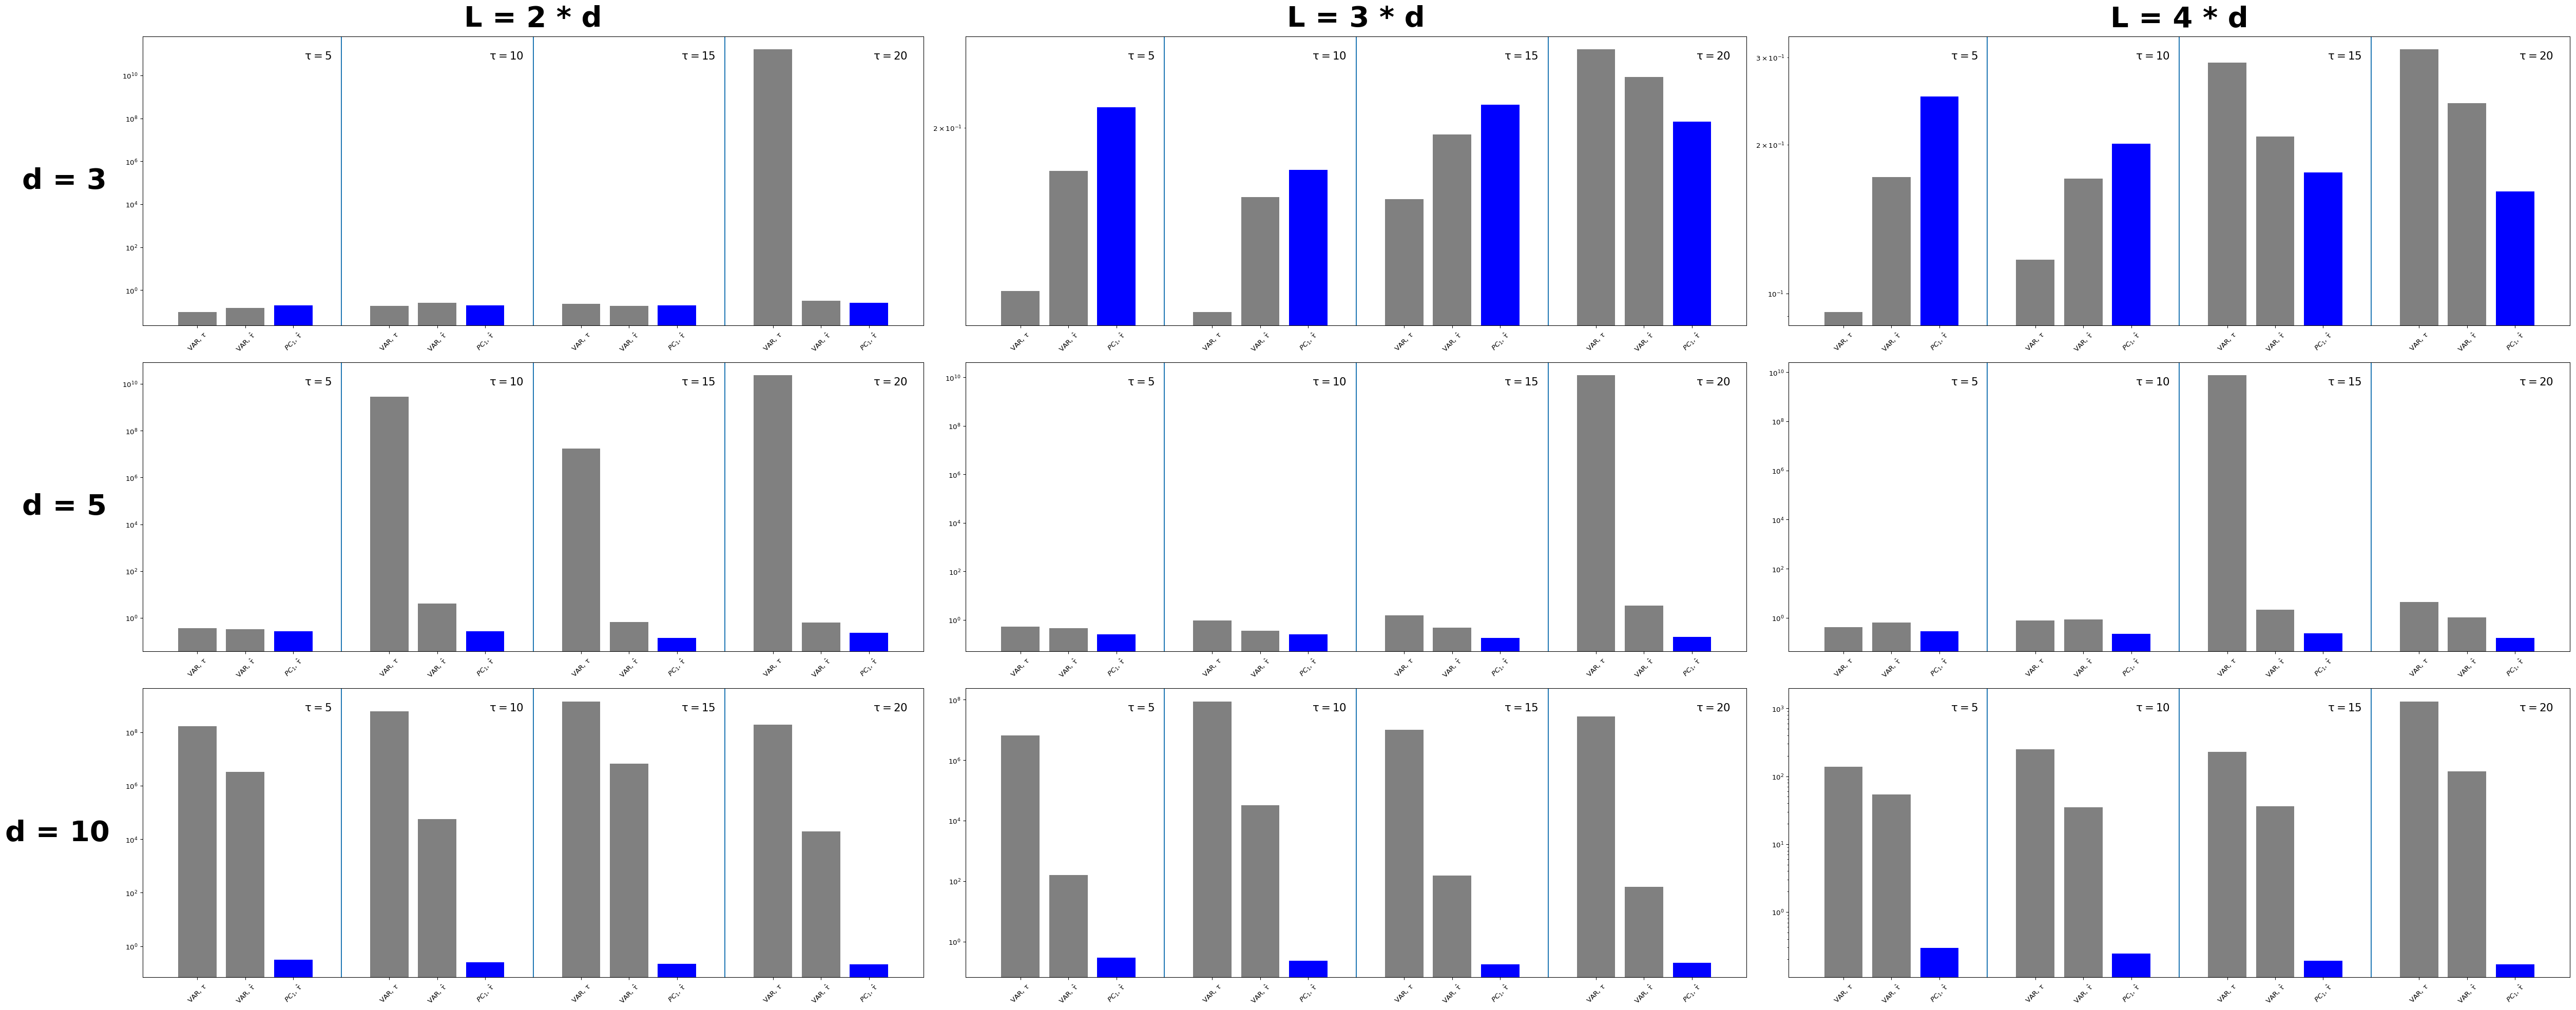

In [218]:
from itertools import product

results_path = 'notebooks/ICML/icml_results_v2/'
results4_agg = pd.read_csv(results_path + 'experiment4_aggregated.csv')
algorithm = 'PC1 incremental'
mse_type = ' - MSE TR'

fig, axes = plt.subplots(len(dimensions), len(incoming_edges), 
                        figsize=(50,20), dpi=96)
for row_idx, dim in enumerate(dimensions):
    for col_idx, in_edges in enumerate(incoming_edges):
        ax = axes[row_idx, col_idx]
        
        cmp_cnt = 3
        all_bar_heights = []
        all_tick_labels = []
        all_colors = []
        for plt_idx, tau in enumerate(taus):
            plt_data = results4_agg[(results4_agg[['dimension', 'edges', 'max time lag'
                                                  ]].values == (dim, in_edges, tau)).all(axis=1)]
            bar_heights = np.sqrt(plt_data[[
#                 'VAR tau-1' + mse_type, 
                'VAR tau' + mse_type,
#                 'VAR tau+1' + mse_type, 
                'estimated VAR' + mse_type,
                algorithm + mse_type
            ]]).median()
            all_bar_heights.extend(bar_heights)
            
            all_colors.extend([
                'grey', 
                'grey', 
#                 'grey', 
                'blue'
            ])
            all_tick_labels.extend([
#                 r'VAR, $\tau-1$', 
                r'VAR, $\tau$', 
#                 r'VAR, $\tau+1$',
                r'VAR, $\hat{\tau}$',
#               algorithm + r', $\hat{\tau}$'])
                r'$PC_{1}$, $\hat{\tau}$'
            ])
            ax.annotate(r'$\mathrm{\tau = ' + str(tau) + r'}$', xy=((cmp_cnt+1)*plt_idx + (cmp_cnt - 0.2), 0.95),
                        xycoords=('data', 'axes fraction'), fontsize=16,
                        horizontalalignment='right', va='top')
        
        for sep_idx in np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1):
            ax.axvline(sep_idx)
        ax.bar(np.delete(np.arange((cmp_cnt+1)*len(taus)-1), np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1)),
               height=all_bar_heights, color=all_colors,
               tick_label=all_tick_labels)
        ax.tick_params(axis='x', rotation=45)
        ax.set_yscale('log')
        

pad = 15
for ax, col in zip(axes[0], [f'L = {in_e} * d' for in_e in incoming_edges]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=42, ha='center', va='baseline', fontweight='bold')

for ax, row in zip(axes[:,0], [f'd = {dim}' for dim in dimensions]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=42, ha='right', va='center', fontweight='bold')

plt.tight_layout()
fig.show()

In [143]:
results4_agg.columns

Index(['dimension', 'max time lag', 'edges', 'autocorr', 'run',
       'PC1 incremental tau estimate', 'PC1 incremental - MSE full',
       'PC1 incremental - MSE TR', 'PC1 incremental - MSE FP',
       'PC extensive tau estimate', 'PC extensive - MSE full',
       'PC extensive - MSE TR', 'PC extensive - MSE FP',
       'PC incremental tau estimate', 'PC incremental - MSE full',
       'PC incremental - MSE TR', 'PC incremental - MSE FP',
       'PCMCI incremental tau estimate', 'PCMCI incremental - MSE full',
       'PCMCI incremental - MSE TR', 'PCMCI incremental - MSE FP',
       'VAR tau-1 - MSE full', 'VAR tau - MSE full', 'VAR tau+1 - MSE full',
       'VAR tau-1 - MSE TR', 'VAR tau - MSE TR', 'VAR tau+1 - MSE TR',
       'VAR tau-1 - MSE FP', 'VAR tau - MSE FP', 'VAR tau+1 - MSE FP',
       'VAR tau estimate'],
      dtype='object')

In [151]:
def graph2Var(graph, dim, tau, mapping):
    inverted_mapping = {v: k for k, v in mapping.items()}
    params = np.zeros((dim * tau, dim))

    for x_t in range(dim):
        input_nodes = list(graph.predecessors(mapping[x_t]))
        inputs = np.array([inverted_mapping[x] for x in input_nodes])
        for i in inputs:
            params[i - dim, x_t] = graph.edges[(mapping[i], mapping[x_t])]['weight']
    return params

var_mse_full = []
var_mse_tr = []
var_mse_fp = []

for _, row in results4_agg.iterrows():
    dim, in_edges, tau, autocorr, run = row['dimension'], row['edges'], row['max time lag'], row['autocorr'], row['run']
    
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    true_mapping, true_matrix = transform_ts(generator.ts, tau)
    true_params = graph2Var(generator.graph, dim, tau, true_mapping)
    
    model = VAR(int(row['VAR tau estimate']))
    model.fit(generator.ts)
    est_params = model.params[1:]
    mse_full, mse_tr, mse_fp = evaluate_parameters(true_params, est_params)
    var_mse_full.append(mse_full)
    var_mse_tr.append(mse_tr)
    var_mse_fp.append(mse_fp)

In [153]:
results_path = 'notebooks/ICML/icml_results_v2/'

results4_agg['estimated VAR - MSE full'] = var_mse_full
results4_agg['estimated VAR - MSE TR'] = var_mse_tr
results4_agg['estimated VAR - MSE FP'] = var_mse_fp
results4_agg.to_csv(results_path + f'experiment4_aggregated.csv', index=False)

### Subsection tau estimate

In [227]:
print(results4_agg.groupby(['dimension', 'edges', 'max time lag']).median()[[
    'PC1 incremental tau estimate'
]].to_latex())

\begin{tabular}{lllr}
\toprule
   &   &    &  PC1 incremental tau estimate \\
dimension & edges & max time lag &                               \\
\midrule
3  & 2 & 5  &                           6.0 \\
   &   & 10 &                          10.0 \\
   &   & 15 &                          12.0 \\
   &   & 20 &                          12.0 \\
   & 3 & 5  &                           6.5 \\
   &   & 10 &                          10.5 \\
   &   & 15 &                          13.5 \\
   &   & 20 &                          14.5 \\
   & 4 & 5  &                           7.0 \\
   &   & 10 &                          11.0 \\
   &   & 15 &                          15.5 \\
   &   & 20 &                          19.0 \\
5  & 2 & 5  &                           5.5 \\
   &   & 10 &                          12.0 \\
   &   & 15 &                          15.0 \\
   &   & 20 &                          15.5 \\
   & 3 & 5  &                           7.0 \\
   &   & 10 &                          10.5 \\

/home/Daniel.Thevessen/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


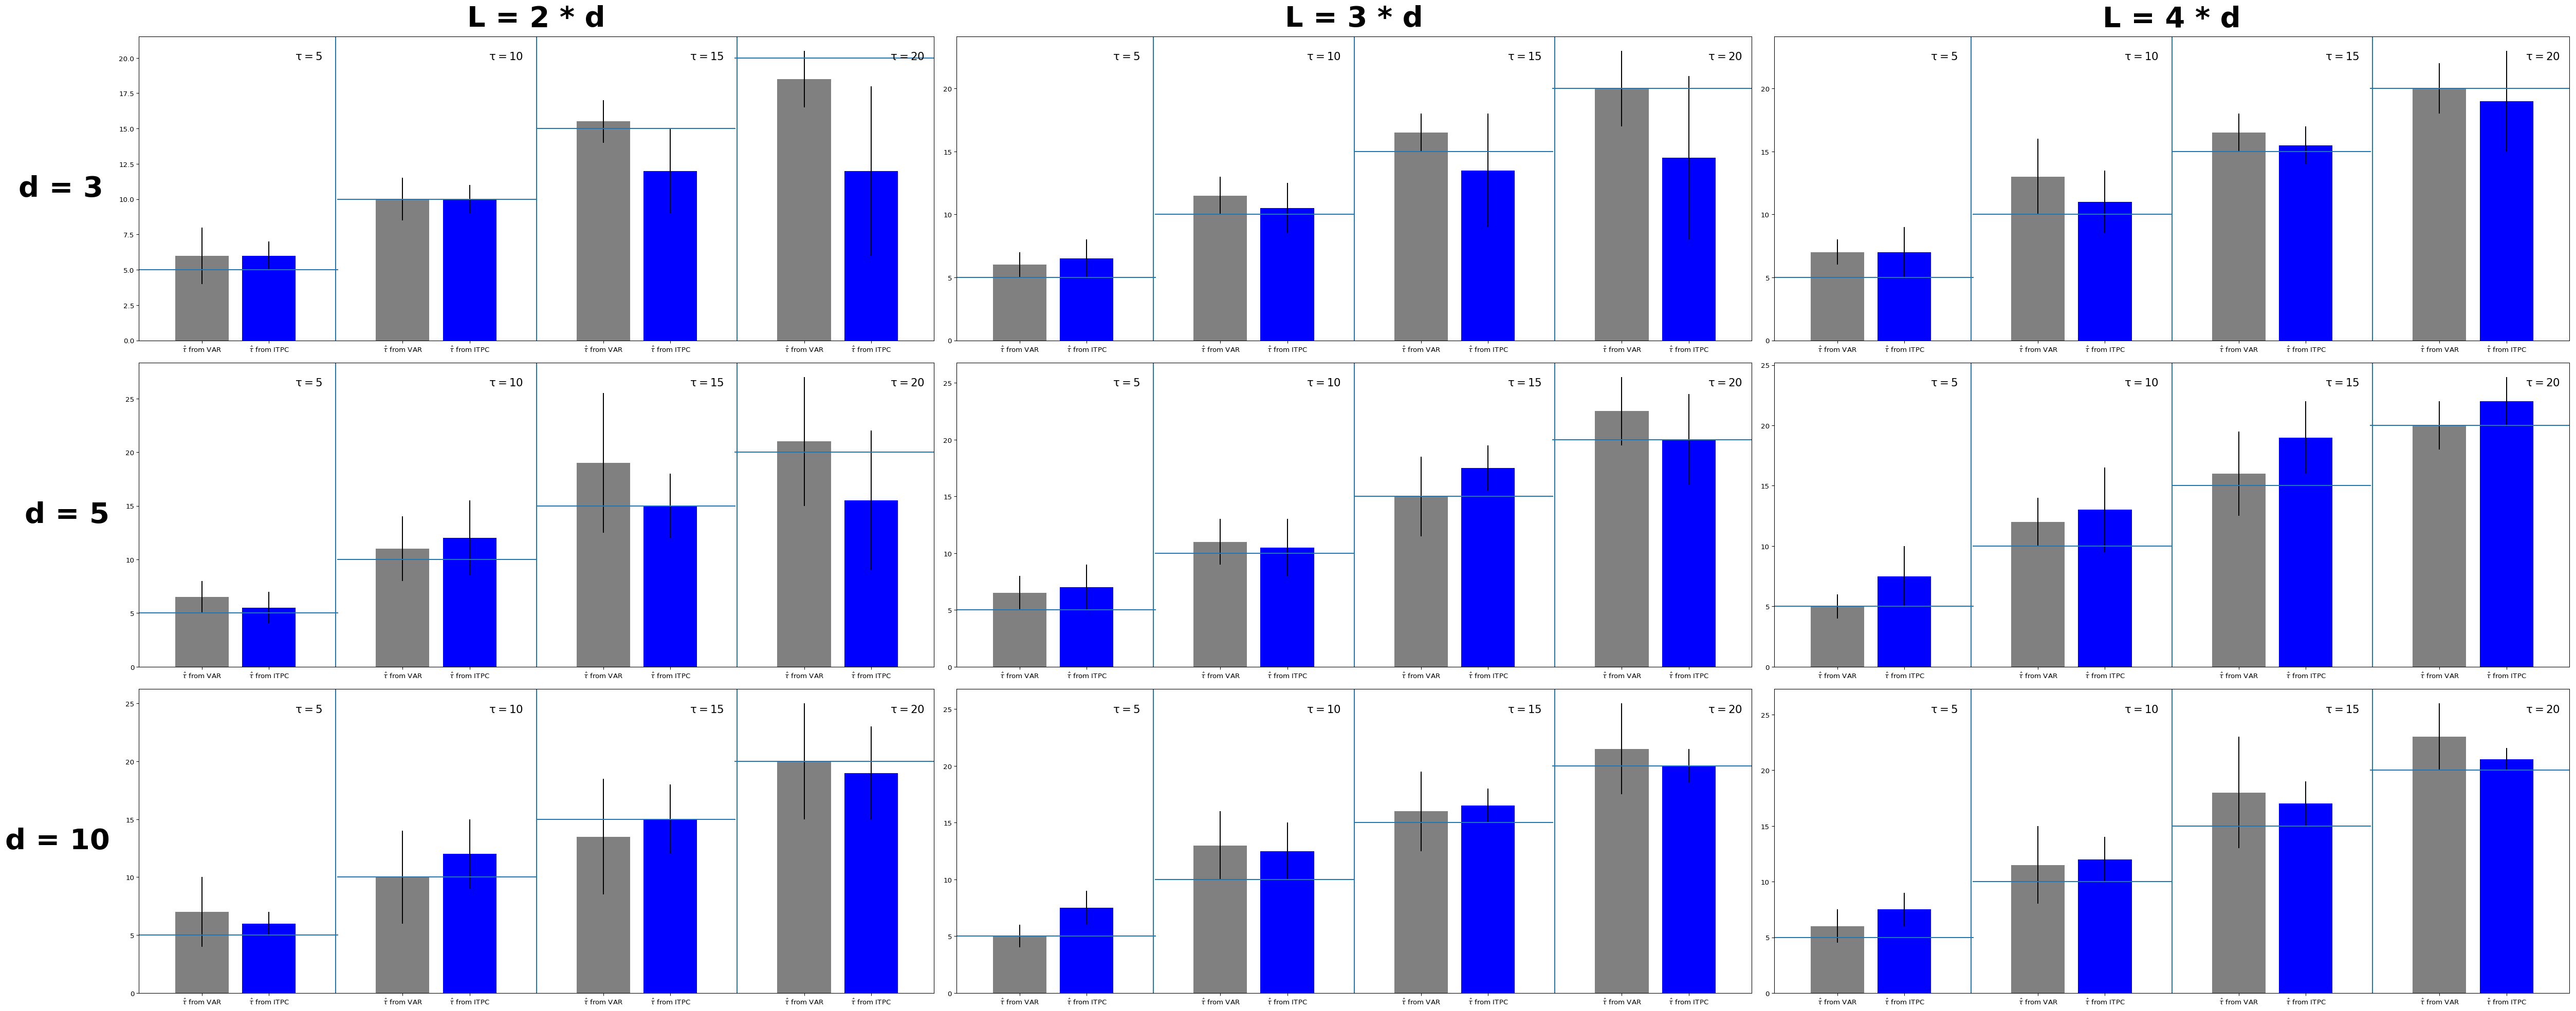

In [17]:
from itertools import product

results_path = 'notebooks/ICML/icml_results_v2/'
results4_agg = pd.read_csv(results_path + 'experiment4_aggregated.csv')
algorithm = 'PC1 incremental'
mse_type = ' - MSE TR'

fig, axes = plt.subplots(len(dimensions), len(incoming_edges), 
                        figsize=(50,20), dpi=96)
for row_idx, dim in enumerate(dimensions):
    for col_idx, in_edges in enumerate(incoming_edges):
        ax = axes[row_idx, col_idx]
        
        cmp_cnt = 2
        all_bar_heights = []
        all_bar_errs = []
        all_tick_labels = []
        all_colors = []
        for plt_idx, tau in enumerate(taus):
            plt_data = results4_agg[(results4_agg[['dimension', 'edges', 'max time lag'
                                                  ]].values == (dim, in_edges, tau)).all(axis=1)]
            bar_heights = plt_data[['VAR tau estimate', 'PC1 incremental tau estimate']].median()
            all_bar_heights.extend(bar_heights)
            
#             bar_errs = plt_data[['VAR tau estimate', 'PC1 incremental tau estimate']].mad()
            bar_errs = abs(plt_data[['VAR tau estimate', 'PC1 incremental tau estimate']] - 
                           plt_data[['VAR tau estimate', 'PC1 incremental tau estimate']].median()
                       ).median()
            all_bar_errs.extend(bar_errs)
            
            all_colors.extend([
                'grey',
                'blue'
            ])
            all_tick_labels.extend([
                r'$\hat{\tau}$ from VAR',
                r'$\hat{\tau}$ from ITPC'
            ])
            ax.annotate(r'$\mathrm{\tau = ' + str(tau) + r'}$', xy=((cmp_cnt+1)*plt_idx + (cmp_cnt - 0.2), 0.95),
                        xycoords=('data', 'axes fraction'), fontsize=16,
                        horizontalalignment='right', va='top')
            
            ax.axhline(tau, xmin=plt_idx/len(taus), xmax=(plt_idx + 1)/len(taus))
        
        for sep_idx in np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1):
            ax.axvline(sep_idx)
        ax.bar(np.delete(np.arange((cmp_cnt+1)*len(taus)-1), np.arange(cmp_cnt, (cmp_cnt+1)*len(taus)-1, cmp_cnt+1)),
               height=all_bar_heights, color=all_colors,
               tick_label=all_tick_labels, yerr=all_bar_errs)
#         ax.tick_params(axis='x', rotation=45)
        

pad = 15
for ax, col in zip(axes[0], [f'L = {in_e} * d' for in_e in incoming_edges]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=42, ha='center', va='baseline', fontweight='bold')

for ax, row in zip(axes[:,0], [f'd = {dim}' for dim in dimensions]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=42, ha='right', va='center', fontweight='bold')

plt.tight_layout()
fig.show()

# Experiment 5

In [10]:
data_path = 'notebooks/ICML/icml_data_v2/'
results_path = 'notebooks/ICML/icml_results_v2/'

result5 = pd.read_csv(results_path + 'experiment5.csv')

In [11]:
result5.columns

Index(['PC1 incremental - FDR', 'PC1 incremental - FPR',
       'PC1 incremental - MSE FP', 'PC1 incremental - MSE TR',
       'PC1 incremental - MSE full', 'PC1 incremental - TPR',
       'PC1 incremental - accuracy', 'PC1 incremental - f1-score',
       'PC1 incremental - matthews_corrcoef', 'PC1 incremental - precision',
       'PC1 tau - FDR', 'PC1 tau - FPR', 'PC1 tau - MSE FP',
       'PC1 tau - MSE TR', 'PC1 tau - MSE full', 'PC1 tau - TPR',
       'PC1 tau - accuracy', 'PC1 tau - f1-score',
       'PC1 tau - matthews_corrcoef', 'PC1 tau - precision', 'PC1 tau+1 - FDR',
       'PC1 tau+1 - FPR', 'PC1 tau+1 - MSE FP', 'PC1 tau+1 - MSE TR',
       'PC1 tau+1 - MSE full', 'PC1 tau+1 - TPR', 'PC1 tau+1 - accuracy',
       'PC1 tau+1 - f1-score', 'PC1 tau+1 - matthews_corrcoef',
       'PC1 tau+1 - precision', 'PC1 tau+2 - FDR', 'PC1 tau+2 - FPR',
       'PC1 tau+2 - MSE FP', 'PC1 tau+2 - MSE TR', 'PC1 tau+2 - MSE full',
       'PC1 tau+2 - TPR', 'PC1 tau+2 - accuracy', 'PC1 tau+2 - 

In [12]:
(result5['PC1 incremental - f1-score'] - result5['PC1 tau - f1-score']).mean()

-0.019698274848716855

In [14]:
result5[['PC1 incremental - f1-score', 'PC1 tau - f1-score']].std()

PC1 incremental - f1-score    0.216684
PC1 tau - f1-score            0.215412
dtype: float64

In [83]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [133]:
result5.groupby(
    ['max time lag', 'dimension', 'incoming edges', 'autocorr']
).agg(['std'])[['PC1 incremental - accuracy', 'PC1 tau - accuracy']].mean()

PC1 incremental - accuracy  std    0.004115
PC1 tau - accuracy          std    0.004654
dtype: float64

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


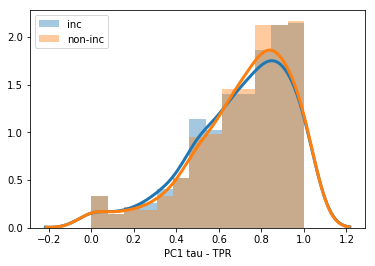

In [105]:
import seaborn as sns

sns.distplot(result5['PC1 incremental - TPR'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'inc')

sns.distplot(result5['PC1 tau - TPR'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'non-inc')
plt.legend()
plt.show()

# Deprecated

In [ ]:
algorithm, stopper, params = 'PCMCI incremental', ICStopper, {'patiency': 2}
col = algorithm + '_bics'

def simulate_stopping(df, stopping, params, col):
    sorted_df = df.sort_values(by='tau estimate')
    idx = stopping.simulate(sorted_df[col].values, **params)
    return sorted_df['tau estimate'].iloc[idx]

agg_se = pd.DataFrame()

for (dim, in_edges, tau, autocorr), res4 in results4.groupby([
    'dimension', 'incoming edges', 'max time lag', 'autocorr']):
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'edges': in_edges, 'autocorr': autocorr}
    
    res3 = results3[(results3[['dimension', 'incoming edges', 'max time lag', 'autocorr'
                                 ]].values == (dim, in_edges, tau, autocorr)).all(axis=1)]
    pred_taus = res3.groupby('run').apply(lambda df: simulate_stopping(df, stopper, params, col))
    pred_errs = [res4[(res4.run == run) & (res4['tau estimate'] == t)][algorithm].iloc[0]
                 for run, t in pred_taus.iteritems()]
    
    df_dict['VAR_tau-1_SE'] = res4[res4['tau estimate'] == tau-1]['complete VAR'].mean() 
    plt.bar(0.2, height=df_dict['VAR_tau-1_SE'], 
            label=r'VAR, $\tau-1$', color='grey', width=0.4)
    df_dict['VAR_tau_SE'] = res4[res4['tau estimate'] == tau]['complete VAR'].mean() 
    plt.bar(0.65, height=df_dict['VAR_tau_SE'], 
            label=r'VAR, $\tau$', color='grey', width=0.4)
    df_dict['VAR_tau+1_SE'] = res4[res4['tau estimate'] == tau+1]['complete VAR'].mean() 
    plt.bar(1.1, height=df_dict['VAR_tau+1_SE'], 
            label=r'VAR, $\tau+1$', color='grey', width=0.4)

    plt.bar(2, height=np.mean(pred_errs), label=algorithm + r', $\hat{\tau}$', width=0.4)
    df_dict[algorithm + '_SE'] = np.mean(pred_errs)
    
    print(df_dict)
    df = pd.DataFrame(df_dict, index=[0])
    agg_se = agg_se.append(df)
    
    plt.ylabel('squared error')
#     plt.yscale('log')
    plt.title(f'tau={tau}, dimensionality={dim}, edge count={in_edges}*dim, autocorr={autocorr}')
    plt.legend()
    plt.show()

### Validate graph

In [ ]:
generator = pickle.load(open(data_path + f't=10_d=3_in=2_autocorr=False_1.pickle', 'rb'))
generator.draw_graph()

In [ ]:
results[(results[['dimension', 'incoming edges', 'max time lag',
                  'autocorr', 'run']].values == (3, 2, 10, False, 1)).all(axis=1)]